### Maze environment
Check out `maze.jl` to see the custom types and functions that define the belief_maze environment. 

In [103]:
include("includes/maze.jl")
Random.seed!(2)
environment, start = generate_nondet_environment(3);


In [46]:
include("includes/value_iteration.jl");
optimal_policy, optimal_values = value_iteration(environment.maze, environment.controller, 0.9, 0.01);
print_maze(environment, start, optimal_policy)

 #↓   .↓   #←  

 .→   G→   #←  

 X↑   .↑   .←  



## Learning belief models

In [5]:
include("includes/gen_simulations.jl");

### Maze parameters

In [16]:

@gen function select_belief_maze_probs(n)::Dict{Pos, Float64}
    maze = Dict{Pos, Float64}()
    for x in 1:n
        for y in 1:n
            pos = Pos(x,y)
            maze[pos] = {pos} ~ beta(2,1)
        end
    end
    return maze
end;

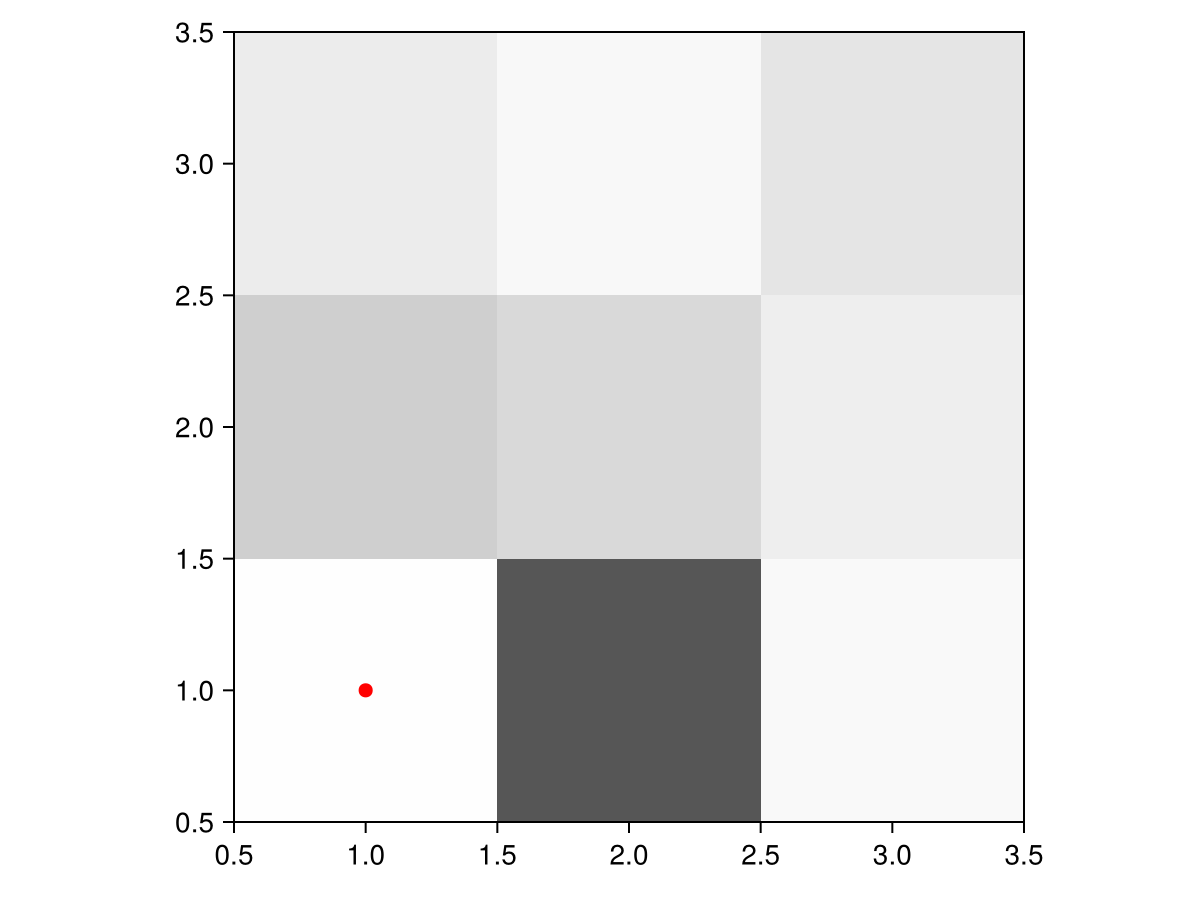

In [84]:
maze = select_belief_maze_probs(3)
plot_belief_maze(BeliefMaze(maze, Pos(1,1)))



### Learning the maze

In [19]:
@gen function sample_goal(n::Int)
    positions = [Pos(x,y) for x in 1:n for y in 1:n]    
    goal_pos = {:goal_index} ~ uniform_discrete(1, length(positions))
    return positions[goal_pos]
end;

In [26]:
@gen function maze_model(environment::Environment, past_policies::Vector{Policy}, start::Pos, episode_length::Int)
    T = length(past_policies)
    n = Int(sqrt(length(past_policies[1])))
    g = {:goal} ~ sample_goal(n)
    maze = {:maze} ~ select_belief_maze_probs(n)
    belief_maze = BeliefMaze(maze, g)

    # HARDCODED FOR NOW
    controller = environment.controller
    
    episodes = []
    for t in 1:T
        policy = past_policies[t]
        episode = {:episode => t} ~ simulate_belief_episode(belief_maze, controller, start, episode_length, policy)
        push!(episodes, episode)
    end
    
    return maze, g
end;

In [27]:
maze_model(environment, [optimal_policy], start, 10)

(Dict{Pos, Float64}(Pos(1, 1) => 0.30273971360875845, Pos(2, 3) => 0.5144239749361424, Pos(2, 1) => 0.9840668518173628, Pos(3, 3) => 0.8563189100613067, Pos(3, 2) => 0.8987511152049473, Pos(3, 1) => 0.6503036784407055, Pos(1, 3) => 0.6440183416747841, Pos(1, 2) => 0.8842929387747528, Pos(2, 2) => 0.6482276333845066), Pos(2, 2))

#### Propose from prior

In [28]:
function block_update_maze(trace, n)
    
    (trace,_) = mh(trace, select(:goal, :maze))
    
    return trace
end;

In [29]:
function update_choicemap(episodes::ChoiceMap, i::Int, episode::Episode, policy::Policy)
    for (j, pos) in enumerate(episode.visited)
        if j < length(episode.visited)
            episodes[:episode => i => j => pos => policy[pos] => :new_pos] = episode.visited[j+1]
            episodes[:episode => i => j => :reward] = episode.rewards[j]
        end
    end
    return episodes
end;

In [85]:
function iterative_thompson(environment::Environment, start::Pos, episode_length::Int, nr_episodes::Int, nr_burn::Int)
    Random.seed!(1)
    n = Int(sqrt(length(environment.maze)))
    policies = [random_policy(n)] 
    episodes = choicemap()
    ep = simulate_episode(environment.maze, environment.controller, start, episode_length, policies[1])
    episodes = update_choicemap(episodes, 1, ep, policies[1])

    trace, sc = generate(maze_model, (environment, policies, start, episode_length), episodes);
    traces = [trace]
    all_traces = []
    
    for t in 2:nr_episodes
        new_burned_traces = []
        for _ in 1:nr_burn
            trace = block_update_maze(trace, n)
            push!(all_traces, trace)
        end
        
        push!(traces, trace)
        
        belief_maze = BeliefMaze(trace[:maze], trace[:goal])
        fig = plot_belief_maze(belief_maze)
        display(fig)
        
        optimal_policy, _ = belief_value_iteration(belief_maze, environment.controller, 0.9, 0.01);

        push!(policies, optimal_policy)
        ep = simulate_episode(environment.maze, environment.controller, start, episode_length, optimal_policy)
        episodes = update_choicemap(episodes, t, ep, optimal_policy)

        (trace, _, _, _) = update(trace, (environment, policies, start, episode_length), (), episodes)
    end

    # fig = plot_grid_field_evolution([get_belief_maze([trace]) for trace in all_traces])

    return policies, traces
end;

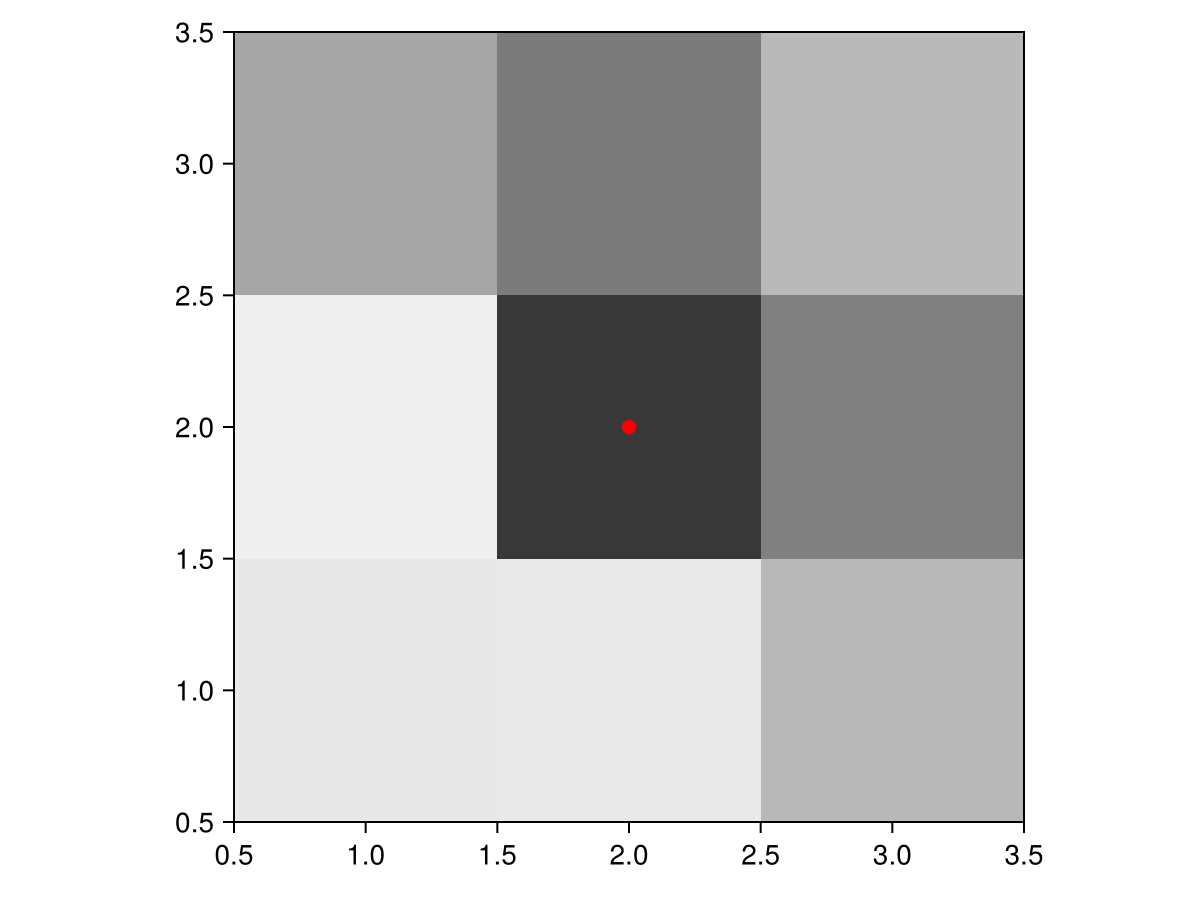

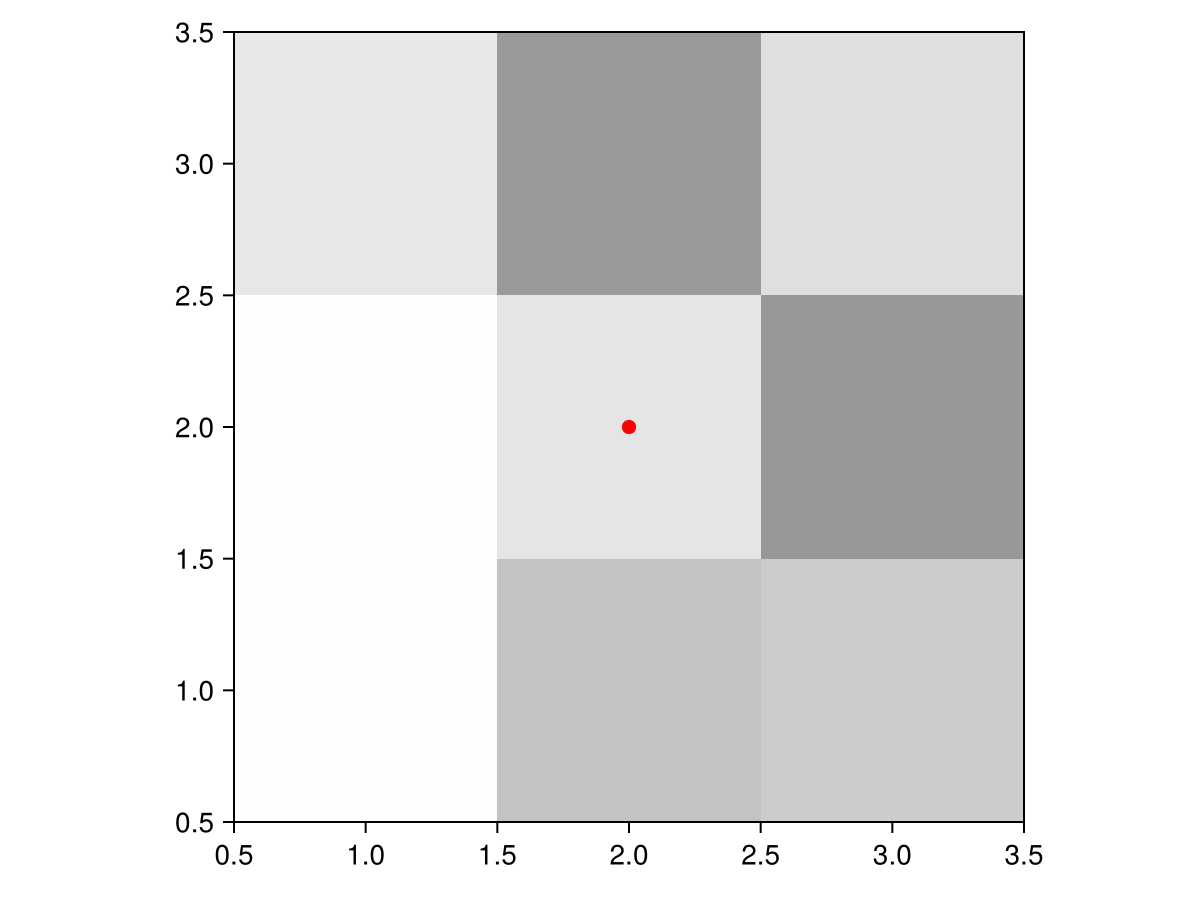

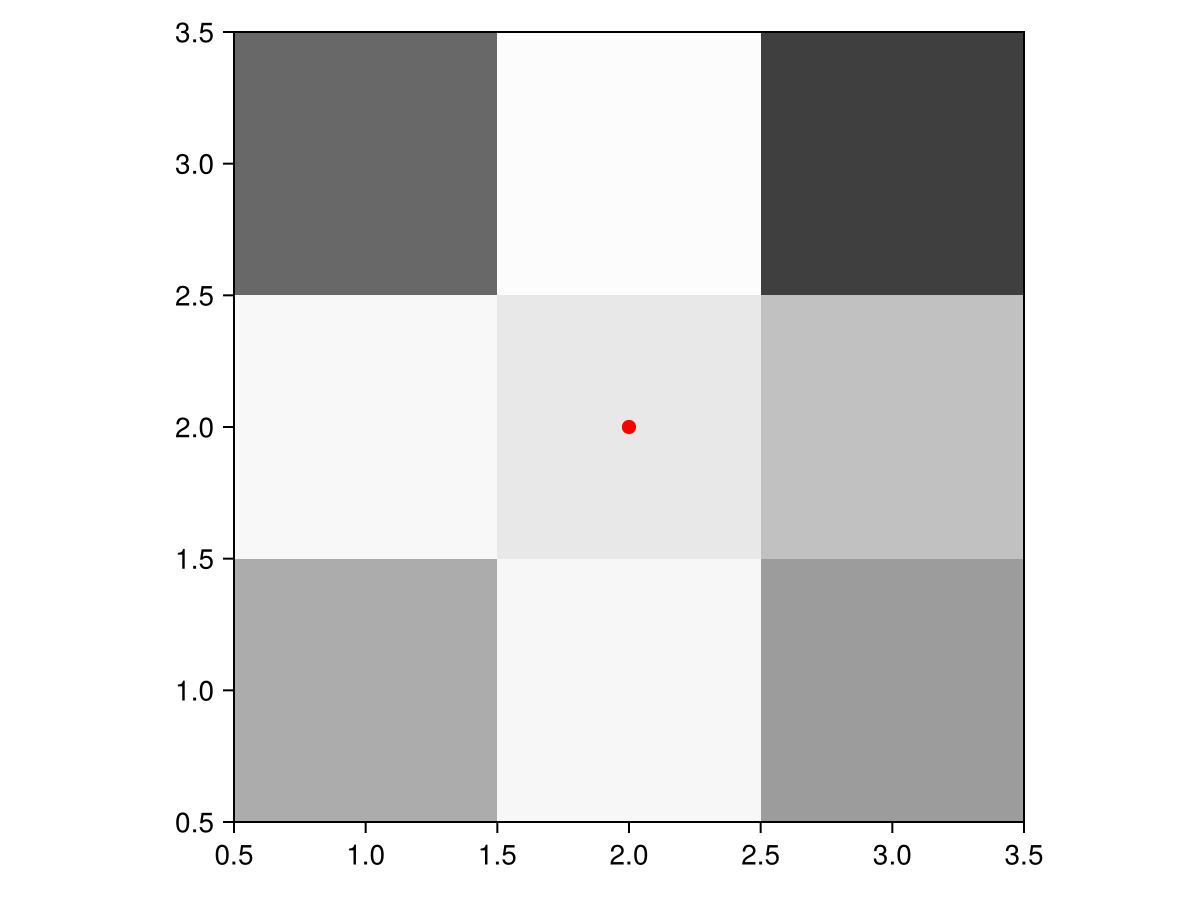

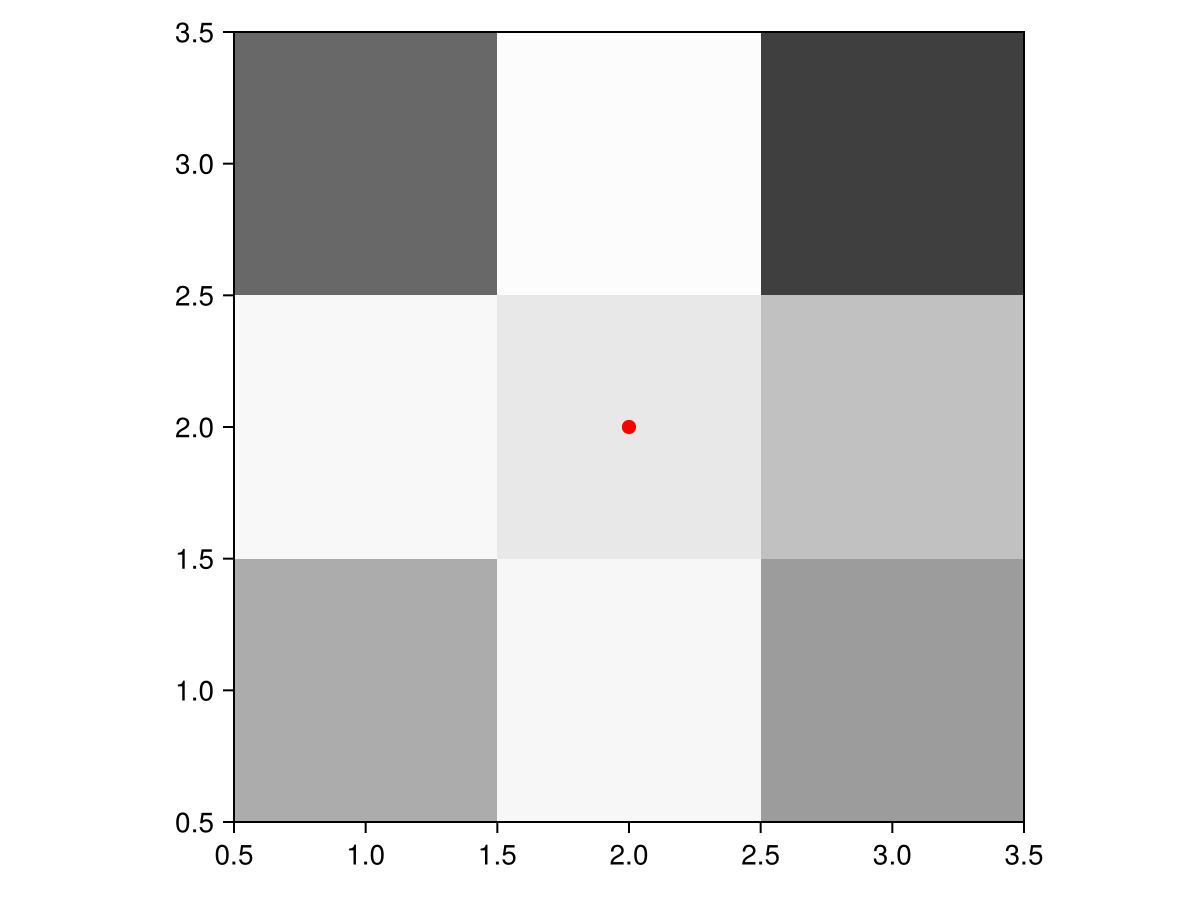

In [86]:
policies, traces = iterative_thompson(environment, start, 100, 5, 100);

In [ ]:
length(traces)

In [88]:
# print_maze(environment, start, policies[1])
# plot_belief_maze(BeliefMaze(traces[1][:maze], traces[1][:goal]))

In [52]:
print_maze(environment, start, policies[end])


 #→   .↓   #←  

 .→   G↑   #←  

 X↑   .↑   .←  



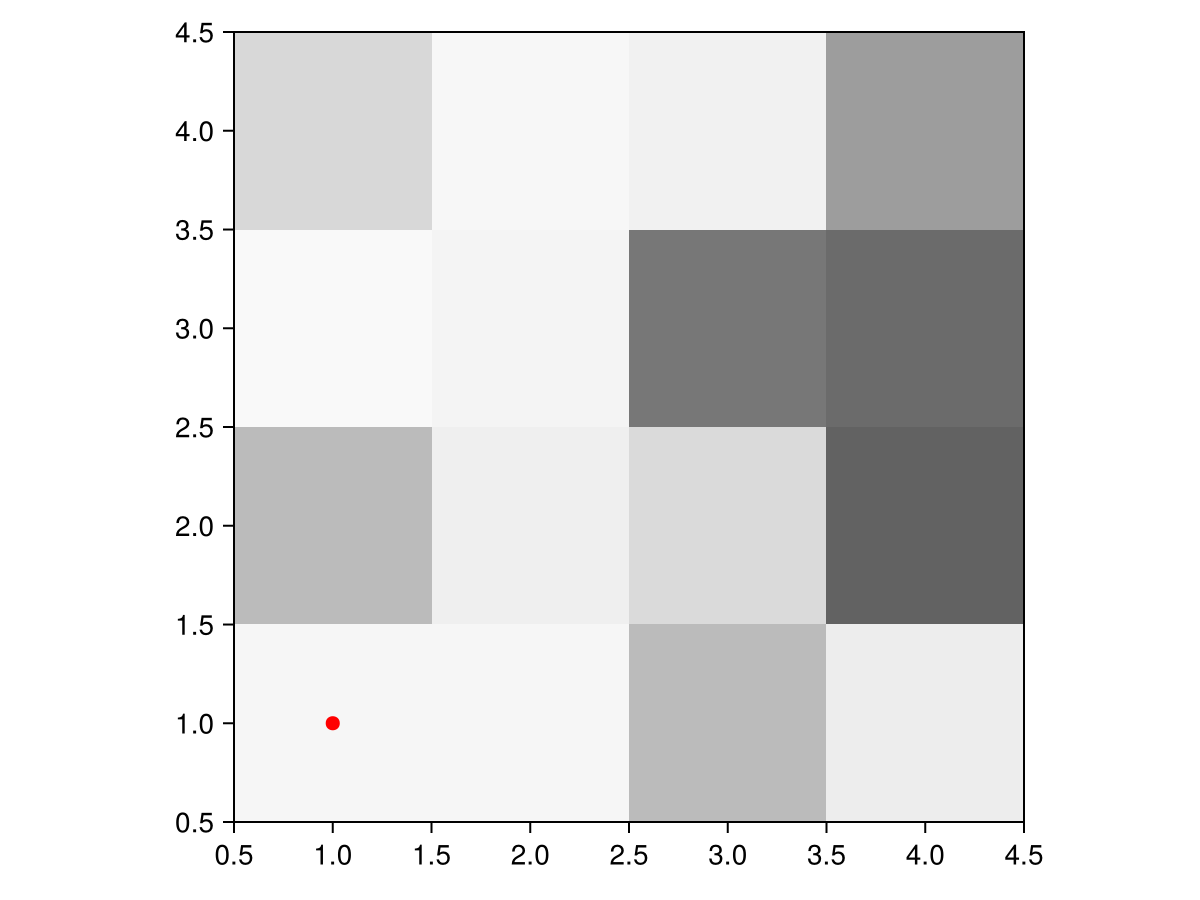

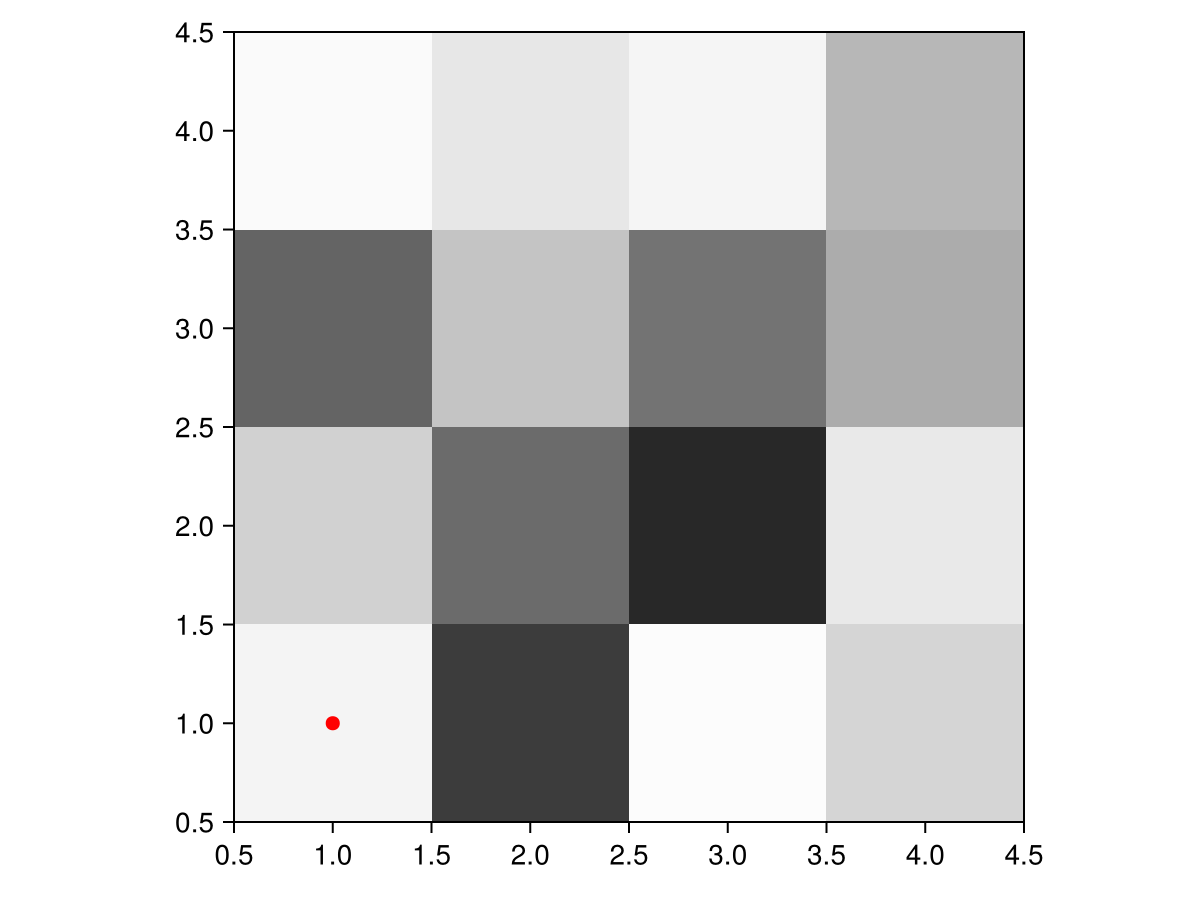

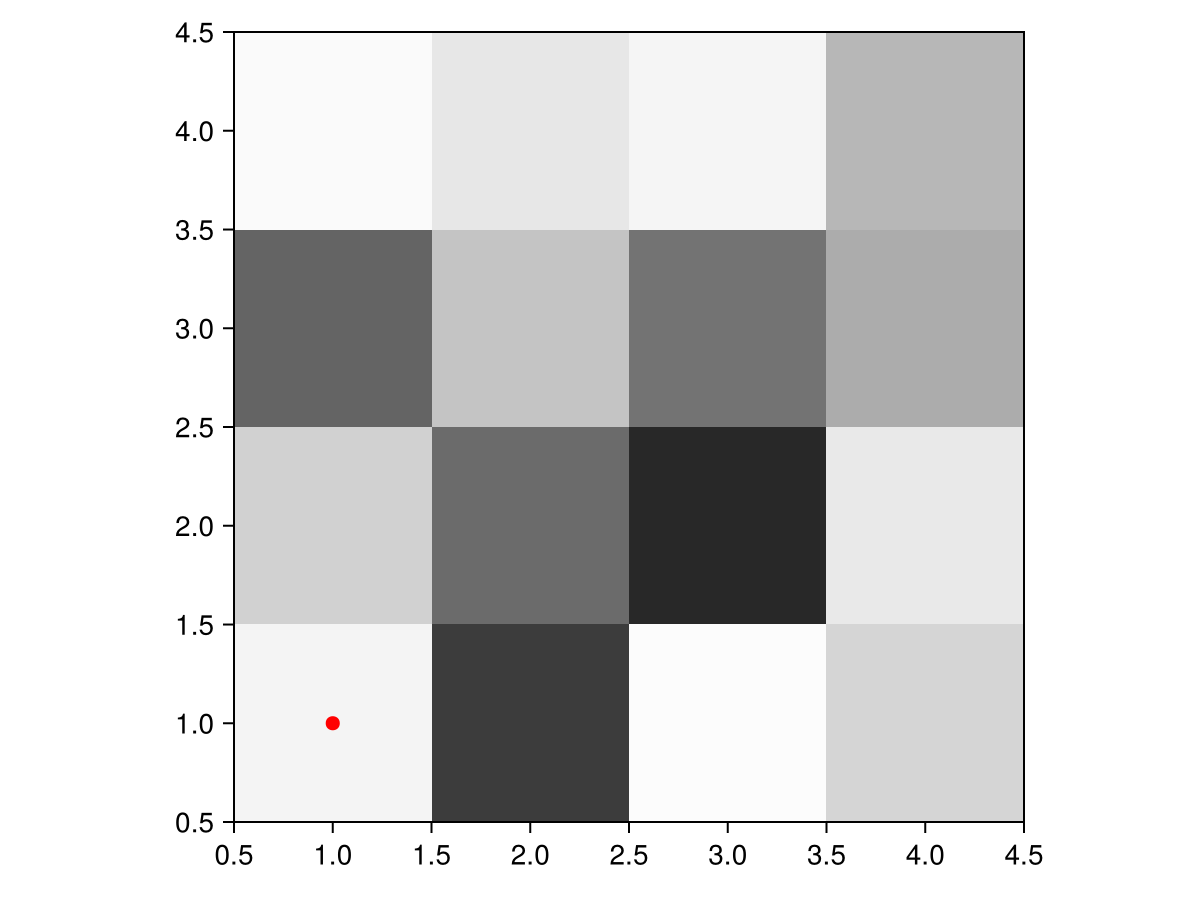

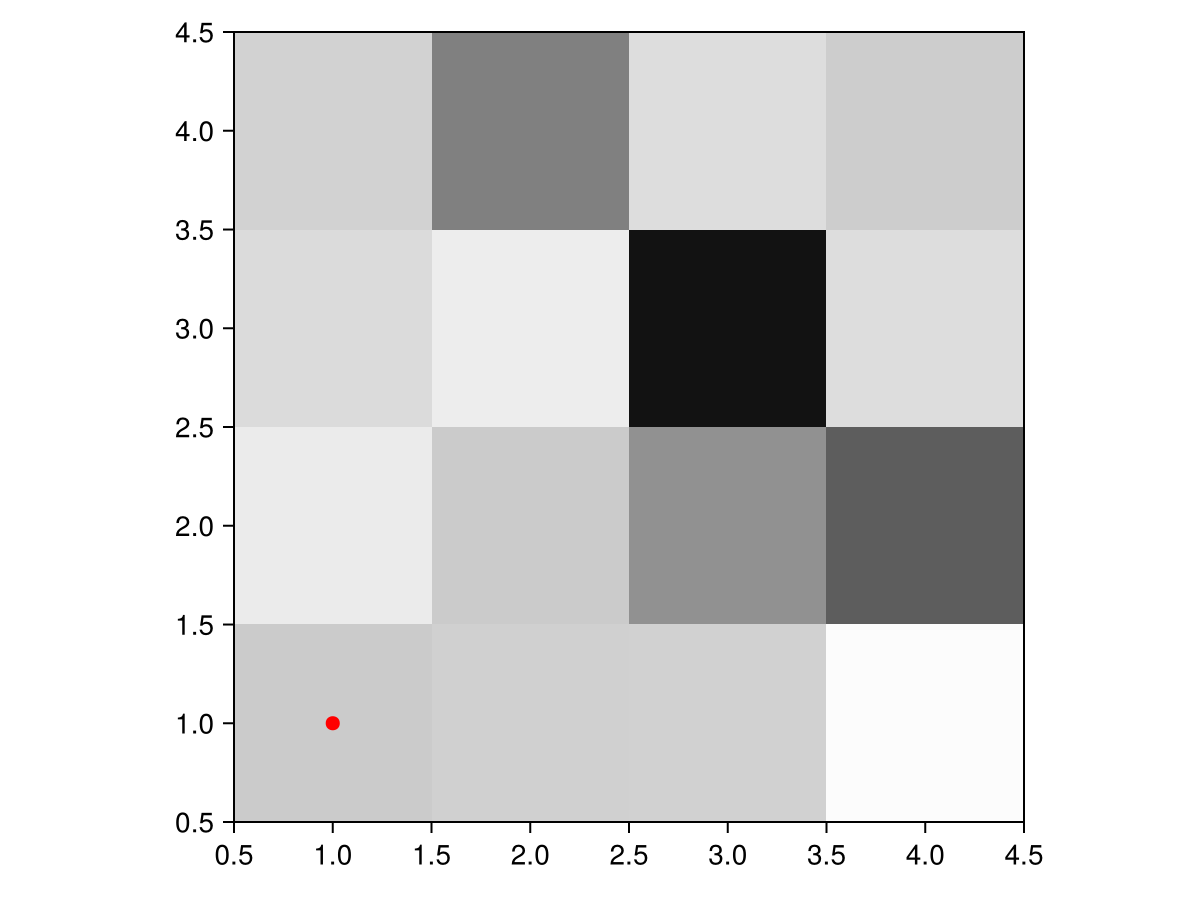

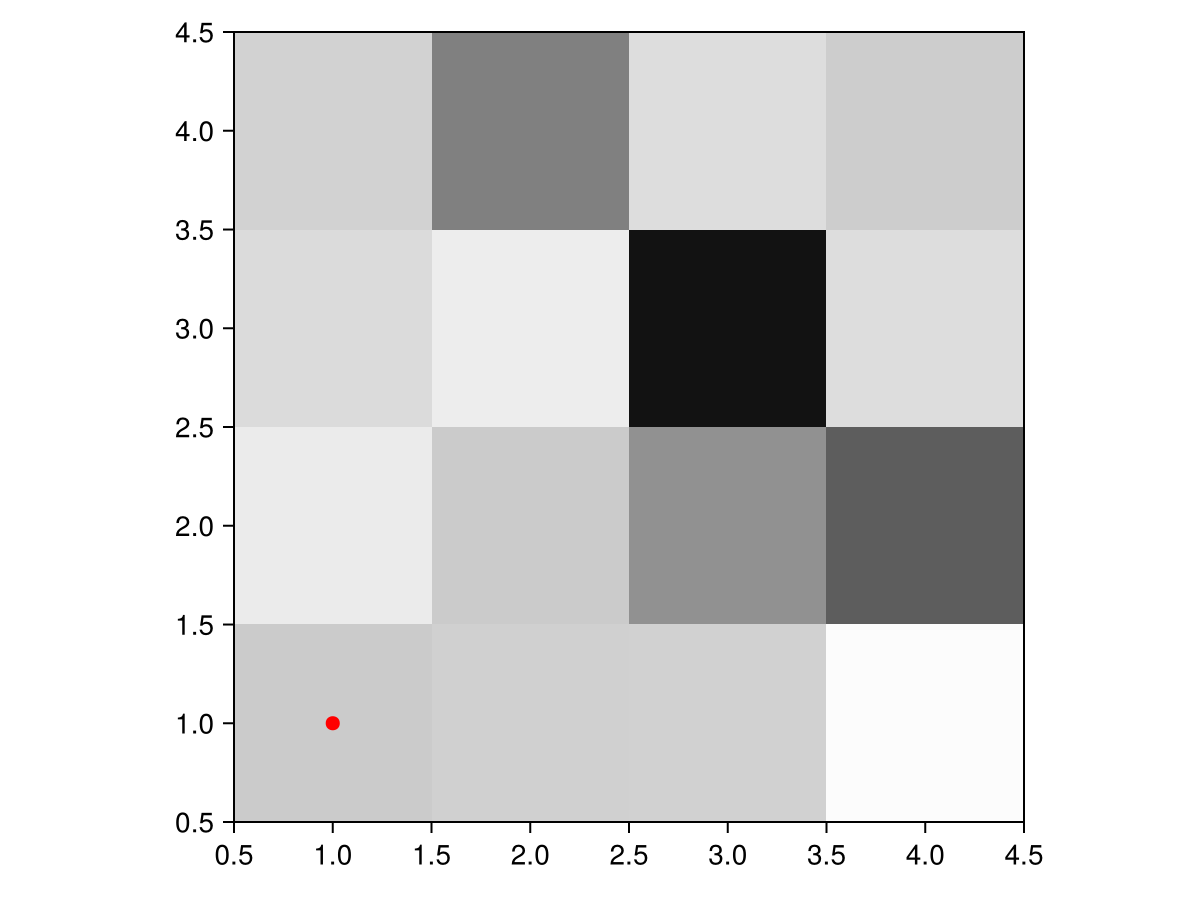

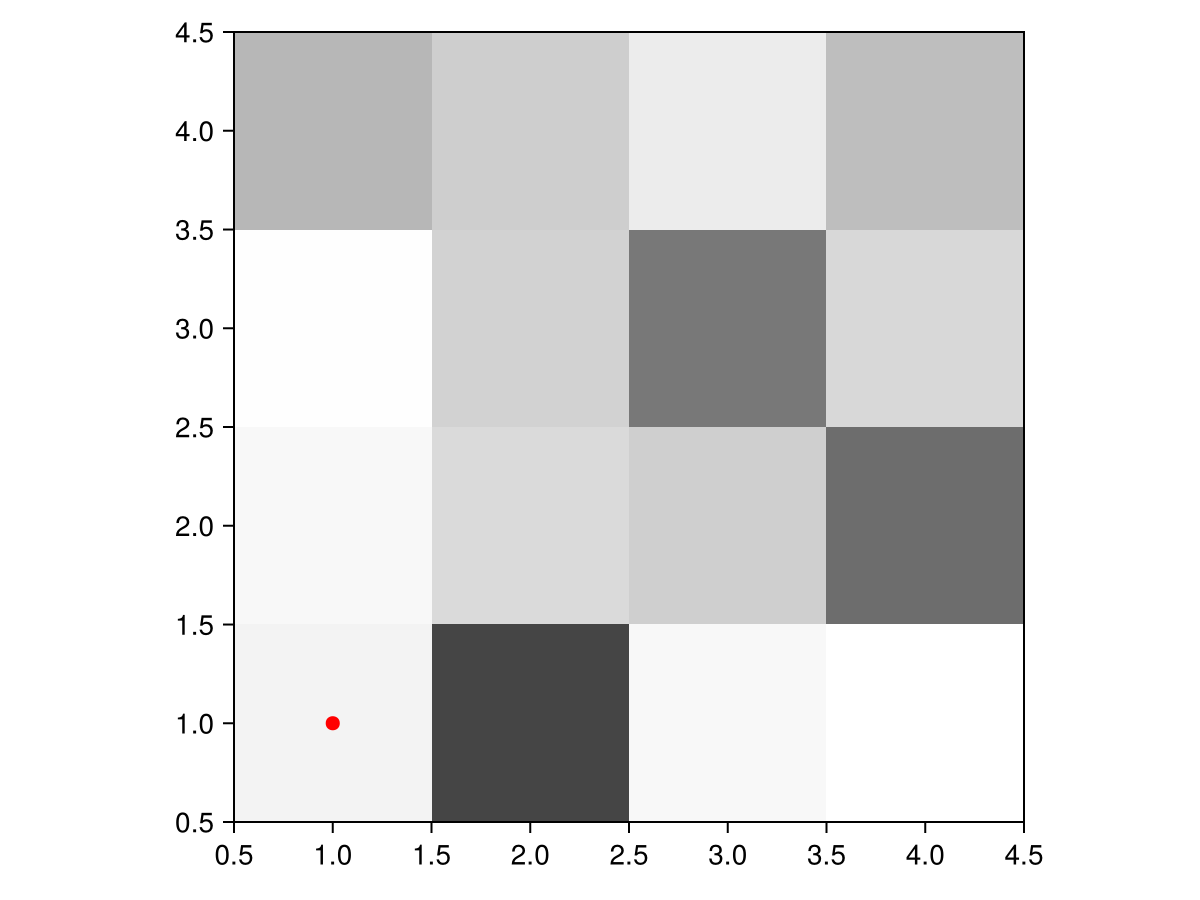

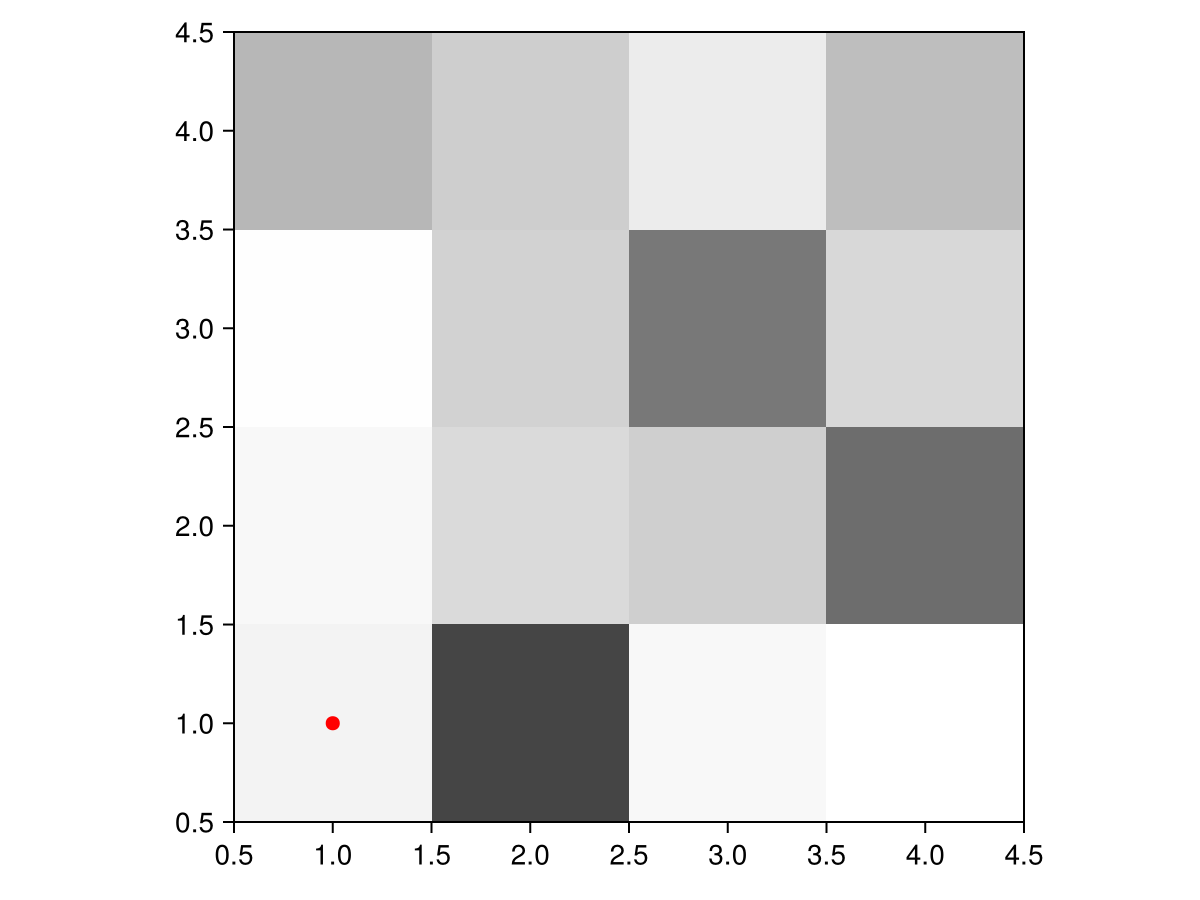

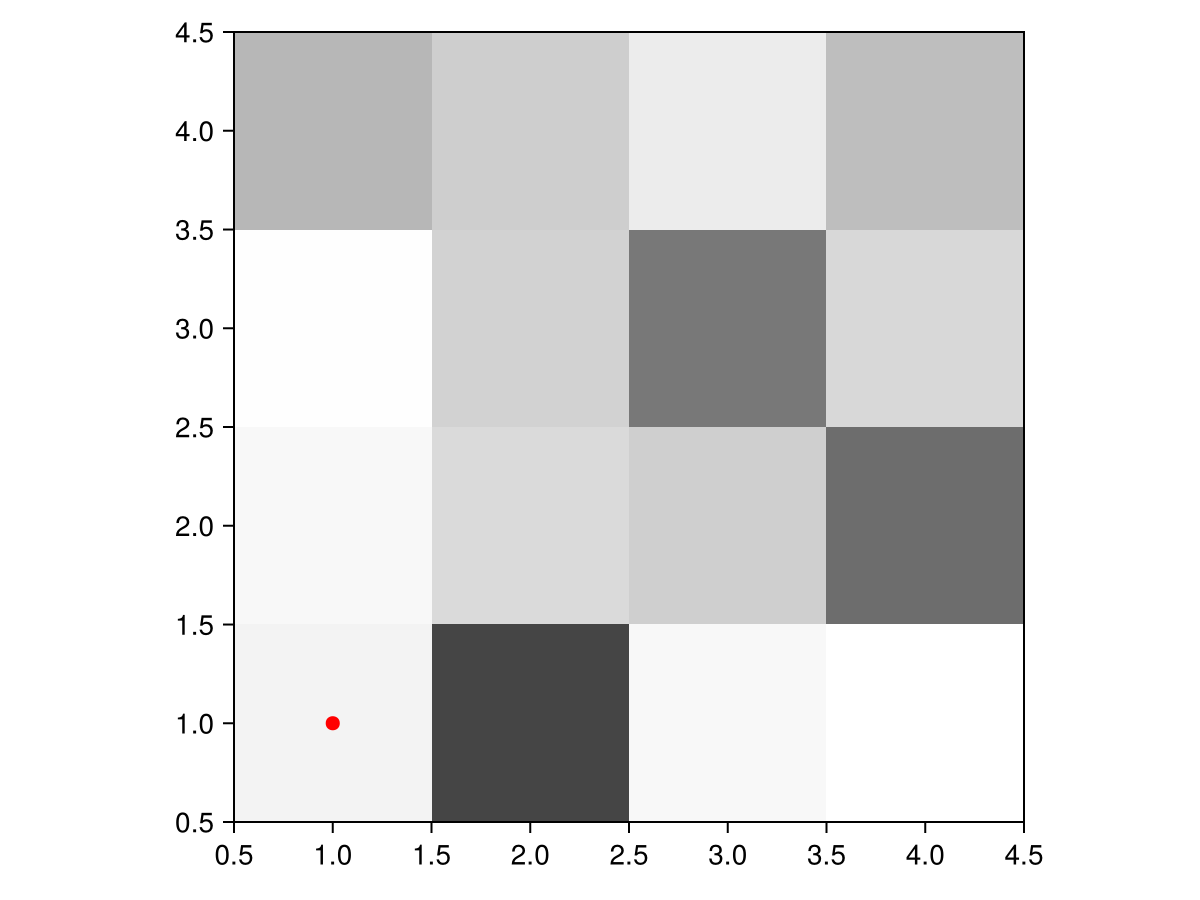

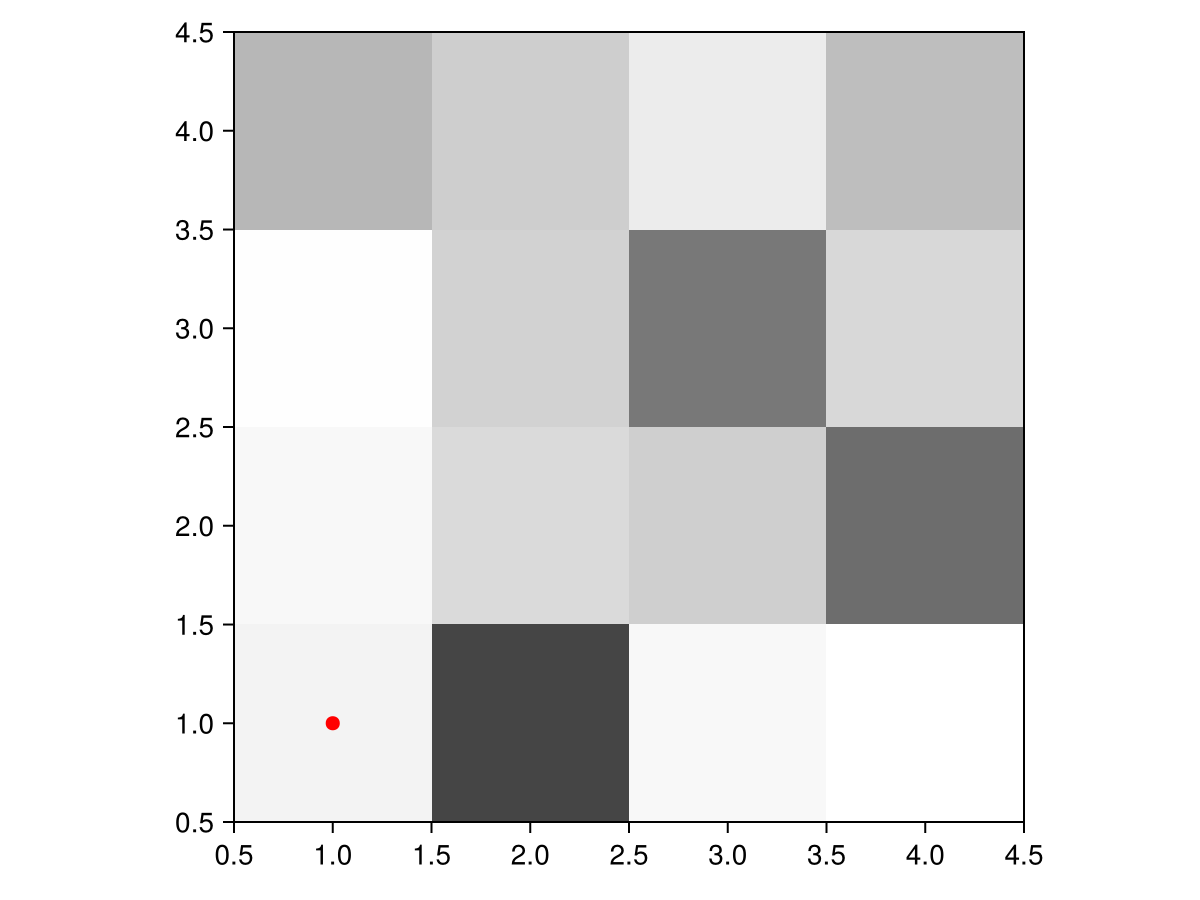

 .↑   X→   .↓   #↑  

 .↑   .→   #↑   .↑  

 .↓   .←   #←   .←  

 G←   #→   #↑   #↓  


 .↓   X↓   .←   #←  

 .↓   .↓   #←   .←  

 .↓   .↓   #←   .←  

 G←   #←   #←   #←  


 .↓   X←   .←   #←  

 .↓   .↓   #←   .↓  

 .↓   .←   #←   .↓  

 G←   #←   #←   #←  


 .↓   X←   .←   #←  

 .↓   .↓   #←   .↓  

 .↓   .←   #←   .↓  

 G←   #←   #←   #←  


 .↓   X↓   .←   #←  

 .↓   .←   #←   .↓  

 .↓   .←   #←   .↓  

 G←   #←   #←   #←  


 .↓   X↓   .←   #←  

 .↓   .←   #←   .↓  

 .↓   .←   #←   .↓  

 G←   #←   #←   #←  


 .↓   X↓   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  


 .↓   X↓   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  


 .↓   X↓   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  


 .↓   X↓   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  




In [89]:
Random.seed!(1)
environment, start = generate_nondet_environment(4);

policies, traces = iterative_thompson(environment, start, 100, 10, 500);


for (i, pol) in enumerate(policies)
    print_maze(environment, start, pol)
    # print_maze(traces[i][:maze], start)
    println()
end


In [56]:
println(traces[end][:goal])

Pos(1, 1)


In [17]:
# Random.seed!(1)
# environment, start = generate_nondet_environment(10);

# policies, traces = iterative_thompson(environment, start, 100, 30, 500);


In [18]:

# print_maze(environment, start, policies[1])
# print_maze(traces[1][:maze], start)

# print_maze(environment, start, policies[end])
# print_maze(traces[end][:maze], start)

#### Propose from belief maze

In [66]:
@gen function propose_goal(trace, start)

    episodes = [trace[:episode => i] for i in 1:length(collect(get_submaps_shallow(get_submap(get_choices(trace), :episode))))]
    n = sqrt(length(trace[:maze]))
    positions = [Pos(x,y) for x in 1:n for y in 1:n]
    old_goal = positions[trace[:goal => :goal_index]]
    goal_pos = nothing
    visited_positions = Dict{Pos,Bool}()

    # check if the goal was already found and save visited positions
    for (i, episode) in enumerate(episodes)
        for (j, reward) in enumerate(episode.rewards)
            pos = episode.visited[j+1]
            if reward == 100 
                goal_pos = pos
            end
            visited_positions[pos] = true
        end
    end
    
    # # sample the goal based on findings
    if goal_pos != nothing
        goal_index = findfirst(x -> x == goal_pos, positions)
        probabilities = [pos == goal_pos ? 100 : 1 for pos in positions]
        probabilities = probabilities / sum(probabilities)
        goal_ix = {:goal => :goal_index} ~ labeled_categorical([i for i in 1:length(positions)], probabilities)
        goal_pos = positions[goal_ix]
    else
        probabilities = [haskey(visited_positions, pos) ? 1 : 100 for pos in positions]
        probabilities = probabilities / sum(probabilities)
        goal_ix = {:goal => :goal_index} ~ labeled_categorical([i for i in 1:length(positions)], probabilities)
        goal_pos = positions[goal_ix]
    end

end;

In [67]:
@gen function propose_field(trace, start, visited_positions::Dict{Pos,Bool}, pos)
    if pos == start
        {:maze => pos} ~ labeled_categorical([1.0], [1.0])
    elseif haskey(visited_positions, pos)
        {:maze => pos} ~ labeled_categorical([1.0], [1.0])
    else
        # sampling from prior
        {:maze => pos} ~ beta(2, 1)
    end
end;
    

In [68]:
function propose_update(trace, start::Pos, history)
    (trace,_) = mh(trace, propose_goal, (start, ))
    
    episodes = [trace[:episode => i] for i in 1:length(collect(get_submaps_shallow(get_submap(get_choices(trace), :episode))))]
    n = sqrt(length(trace[:maze]))
    visited_positions = Dict{Pos,Bool}()

    for (i, episode) in enumerate(episodes)
        for (j, reward) in enumerate(episode.rewards)
            pos = episode.visited[j+1]
            visited_positions[pos] = true
        end
    end
    
    for pos in keys(trace[:maze])
        (trace, _) = mh(trace, propose_field, (start, visited_positions, pos))
    end

    return trace

end;

In [107]:
function iterative_thompson_propose(environment::Environment, start::Pos, episode_length::Int, nr_episodes::Int, nr_burn::Int)
    Random.seed!(1)
    n = Int(sqrt(length(environment.maze)))
    policies = [random_policy(n)] 
    episodes = choicemap()
    ep = simulate_episode(environment.maze, environment.controller, start, episode_length, policies[1])
    episodes = update_choicemap(episodes, 1, ep, policies[1])

    trace, sc = generate(maze_model, (environment, policies, start, episode_length), episodes);
    traces = [trace]
    all_traces = []
    
    for t in 2:nr_episodes
        # burn traces using drift update
        new_burned_traces = []
        for _ in 1:nr_burn
            trace = propose_update(trace, start, all_traces)
            push!(all_traces, trace)
        end
        
        push!(traces, trace)
        
        belief_maze = BeliefMaze(trace[:maze], trace[:goal])
        # fig = plot_belief_maze(belief_maze)
        # display(fig)

        
        optimal_policy, _ = belief_value_iteration(belief_maze, environment.controller, 0.9, 0.01);

        push!(policies, optimal_policy)
        
        ep = simulate_episode(environment.maze, environment.controller, start, episode_length, optimal_policy)
        episodes = update_choicemap(episodes, t, ep, optimal_policy)

        (trace, _, _, _) = update(trace, (environment, policies, start, episode_length), (), episodes)
    end

    # fig = plot_grid_field_evolution([get_belief_maze([trace]) for trace in all_traces])
    plot_density_maze([BeliefMaze(trace[:maze], trace[:goal]) for trace in all_traces])

    return policies, traces
end;

In [108]:
Random.seed!(1)
environment, start = generate_nondet_environment(4);

print_maze(environment.maze, start)

 . X . #
 . . # .
 . . # .
 G # # #


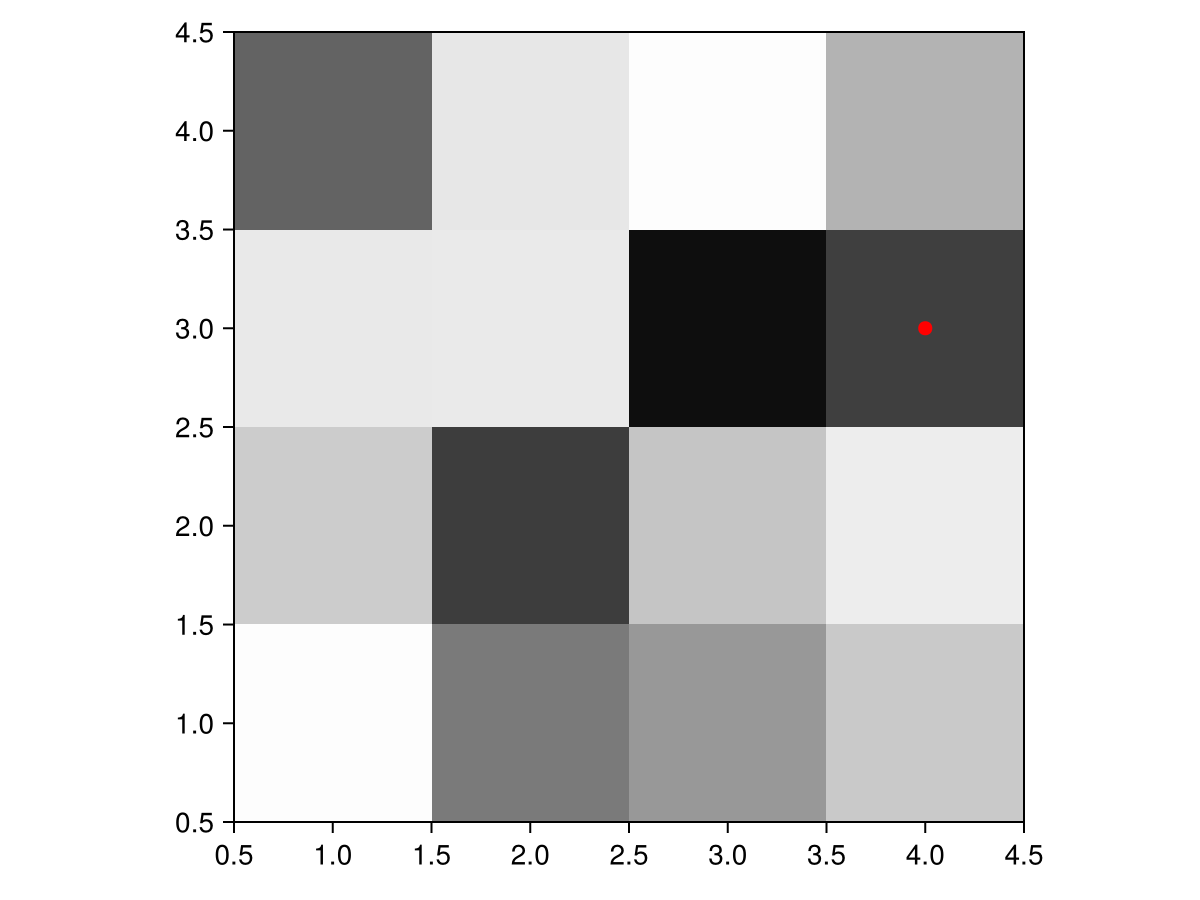

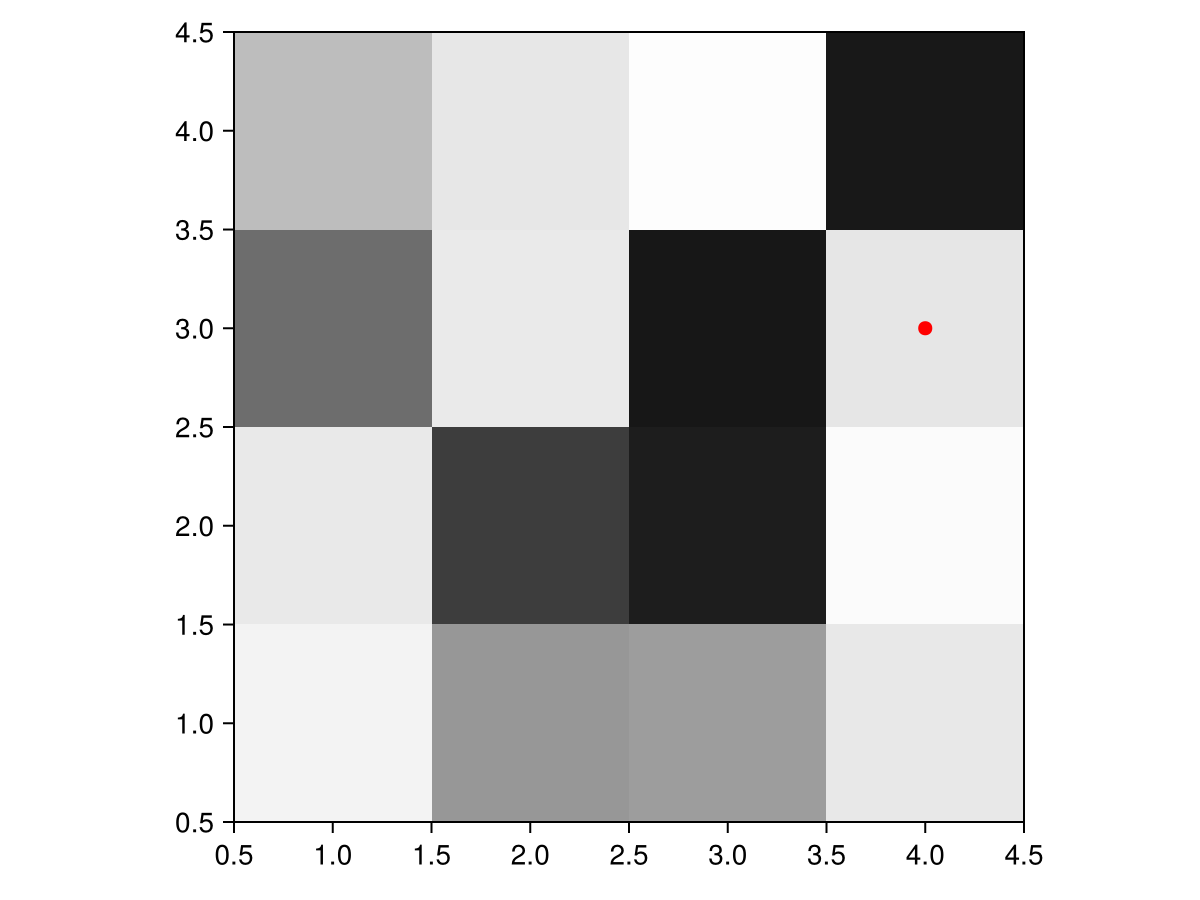

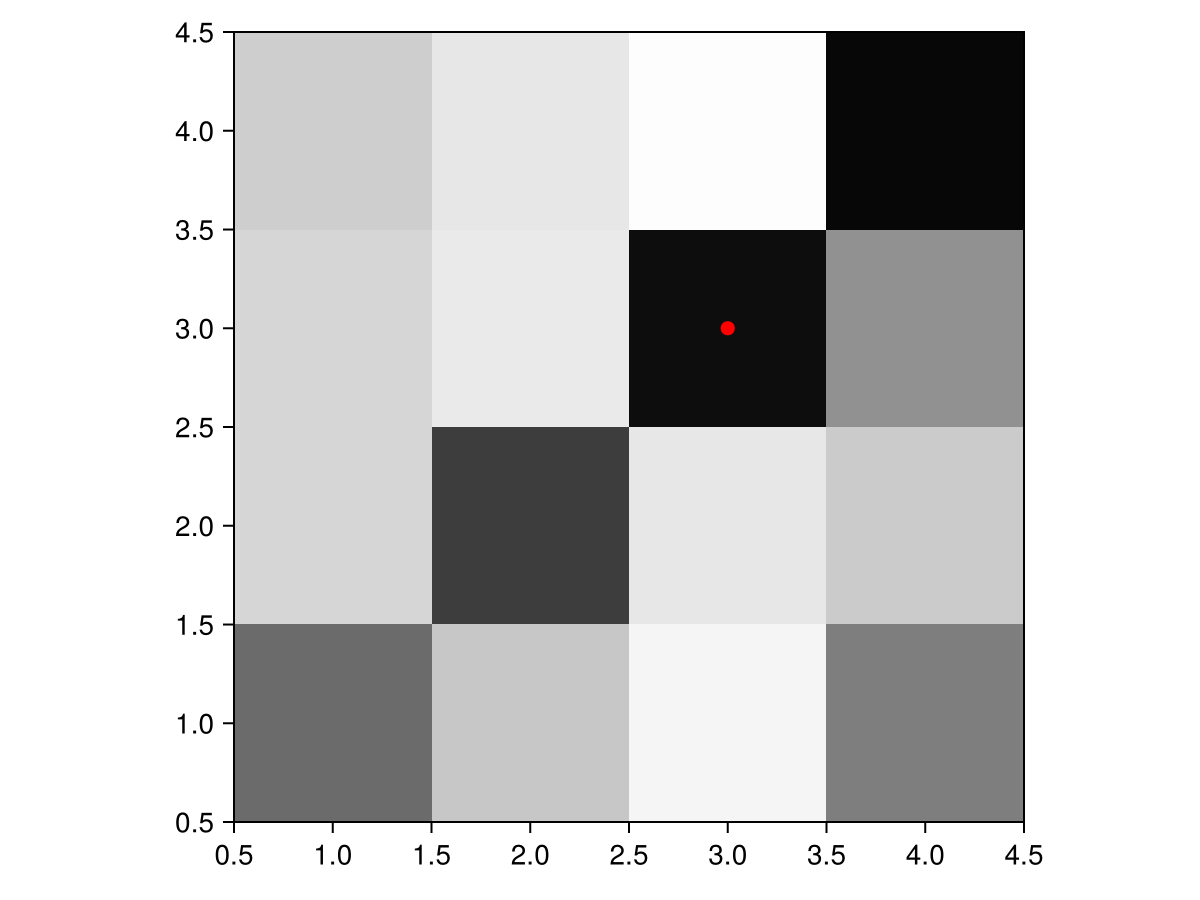

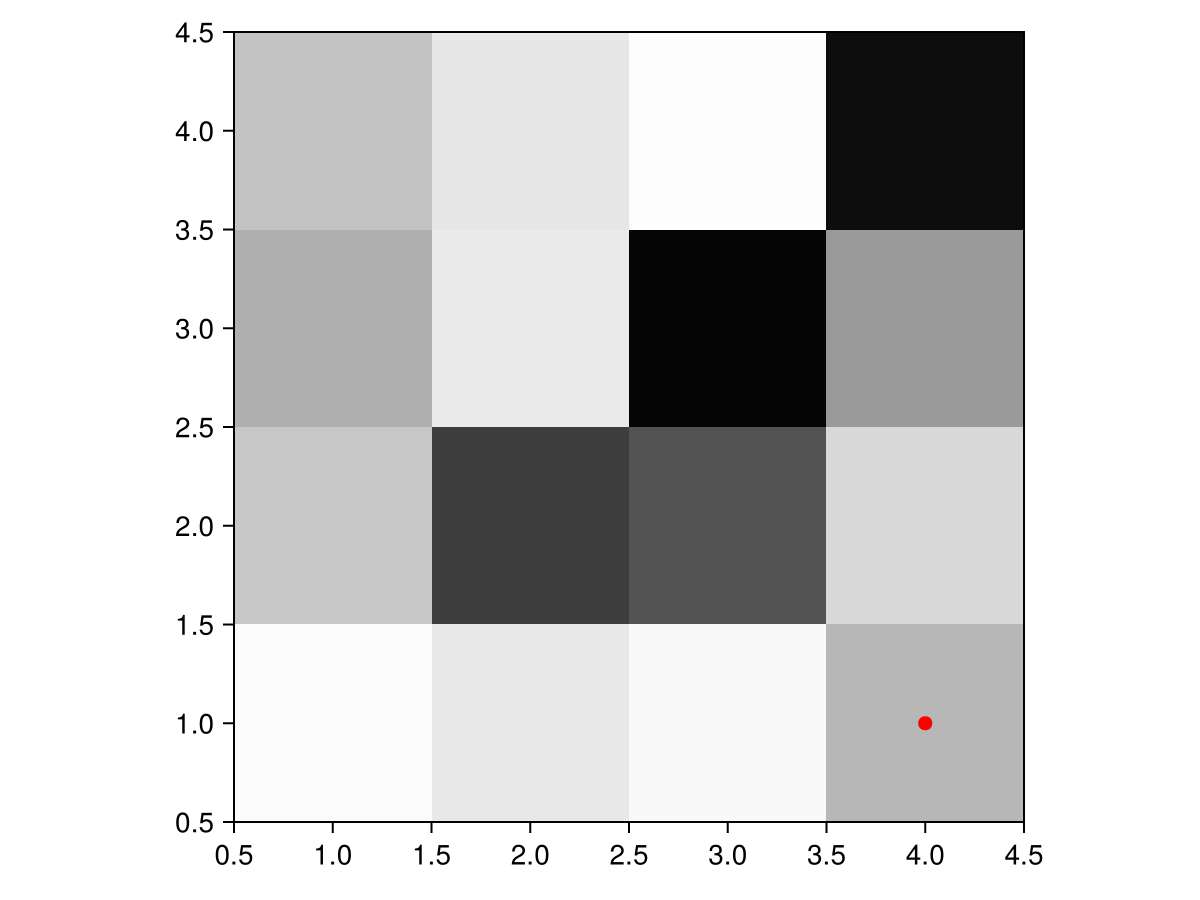

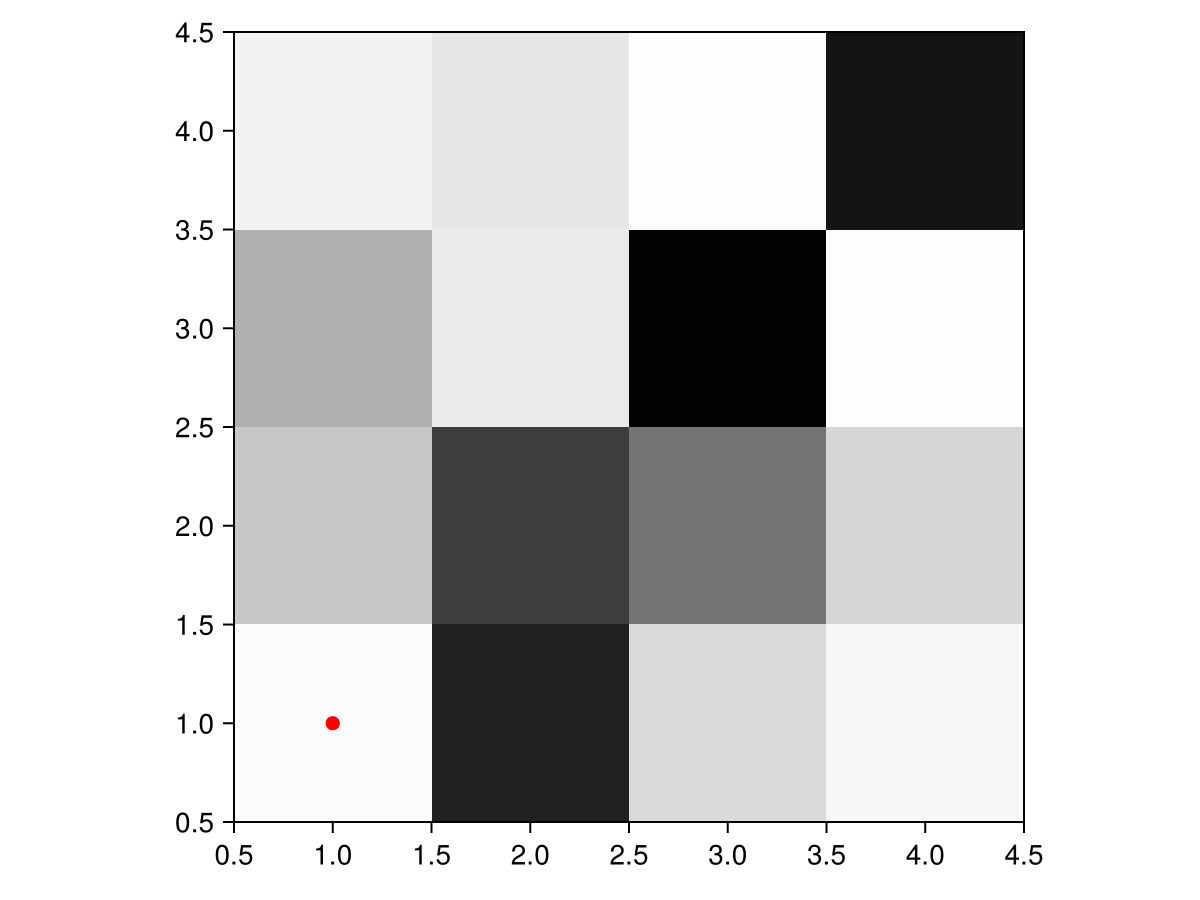

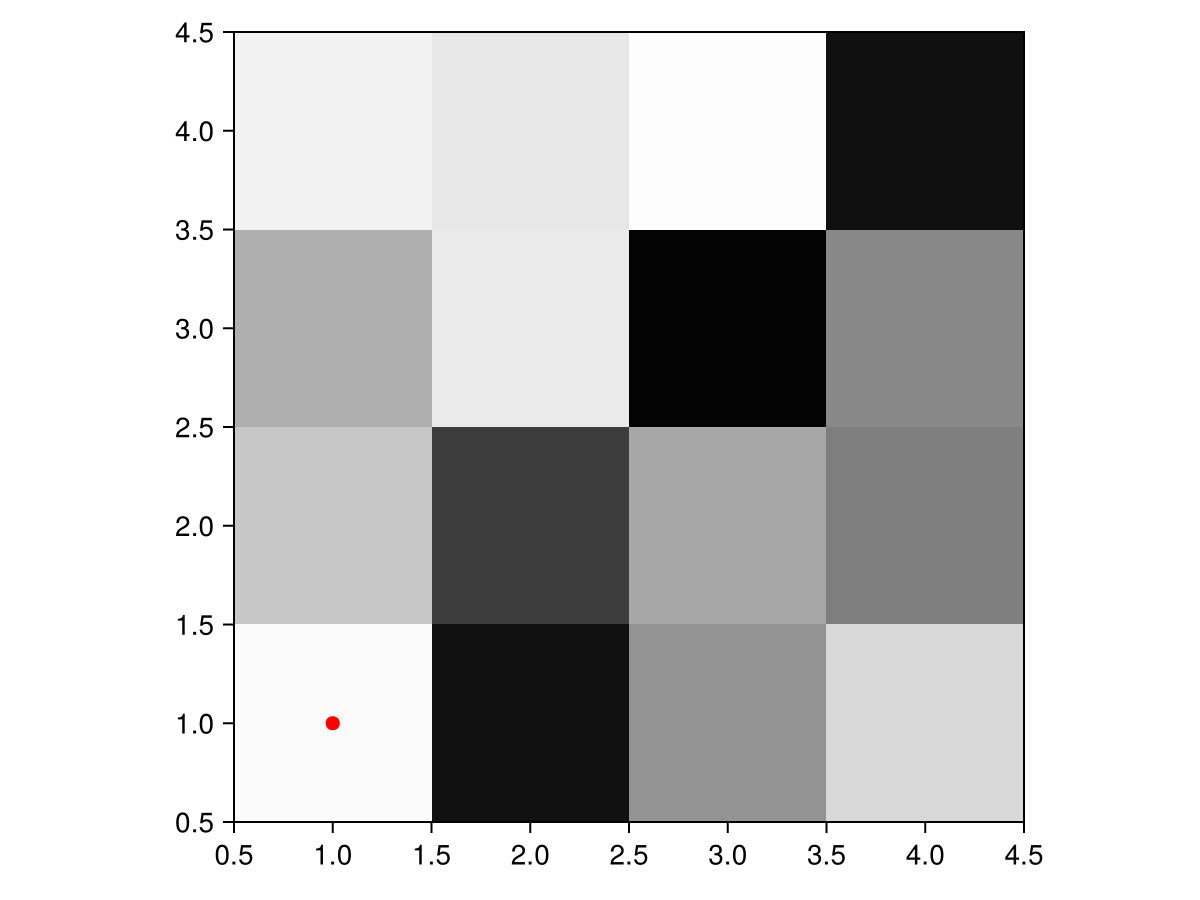

In [92]:
policies, traces = iterative_thompson_propose(environment, start, 30, 7, 310);


In [77]:
println(traces[end][:goal])
print_maze(environment, start, policies[end])

Pos(1, 1)
 .↓   X←   .←   #←  

 .↓   .←   #←   .↓  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  



In [65]:
print_maze(environment.maze, start)

 . X . #
 . . # .
 . . # .
 G # # #


 . . . . . . .
 . G . . . # .
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . . . # . #
 . # # . . . .


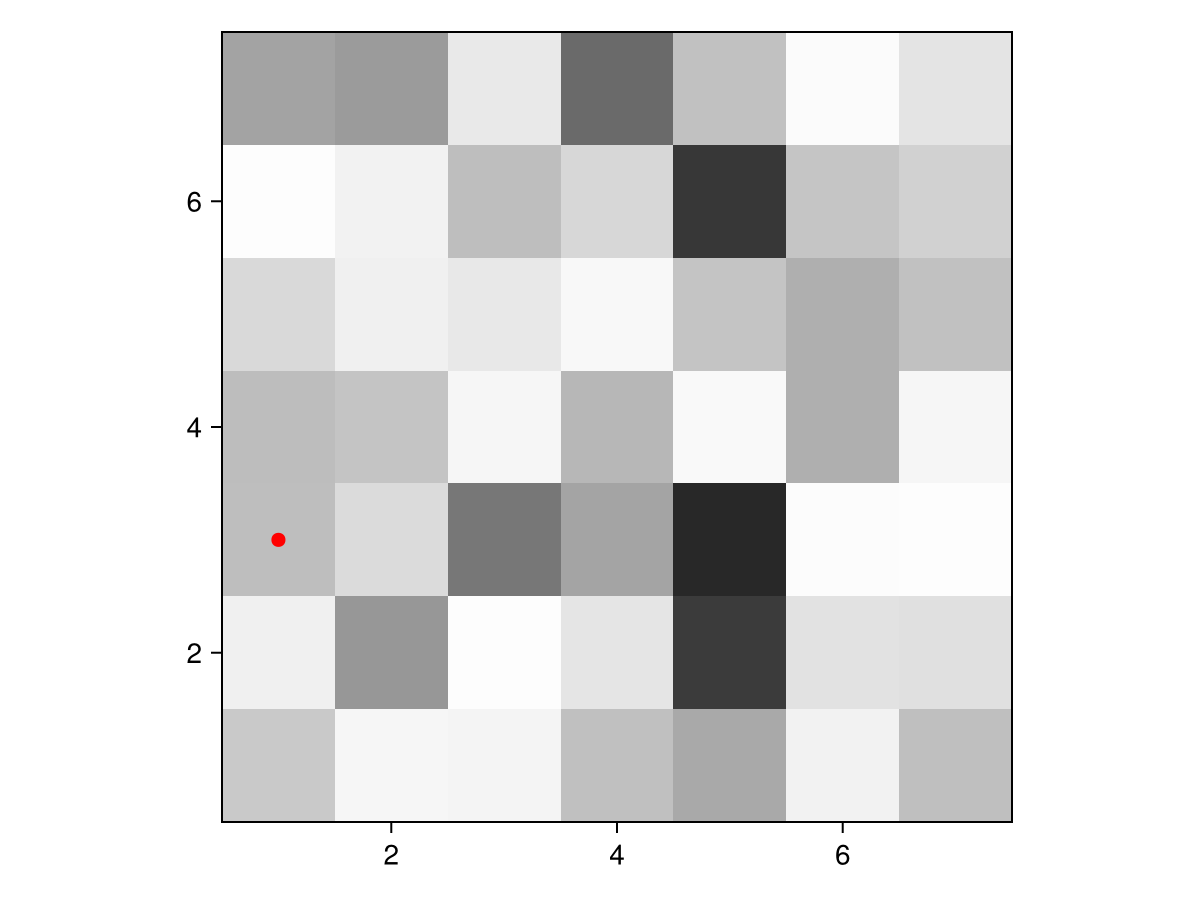

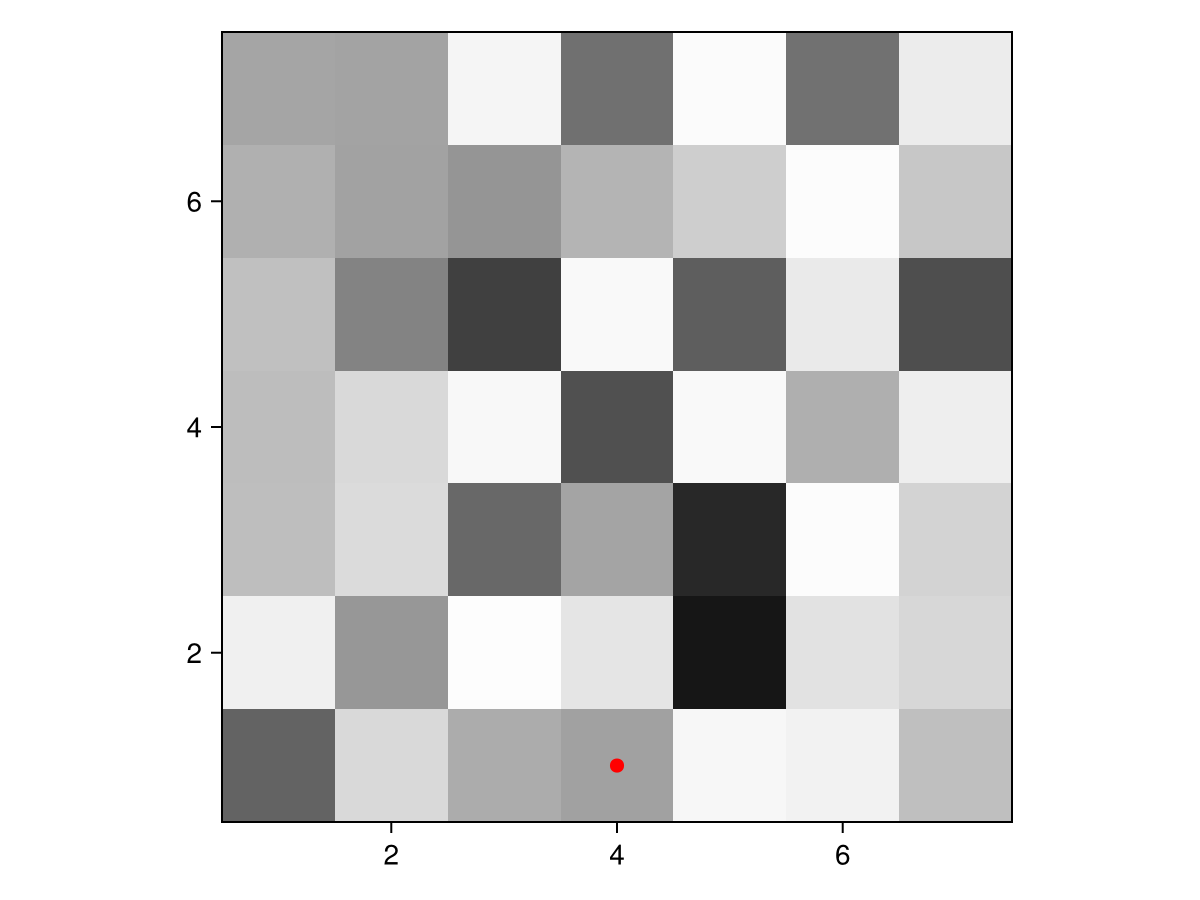

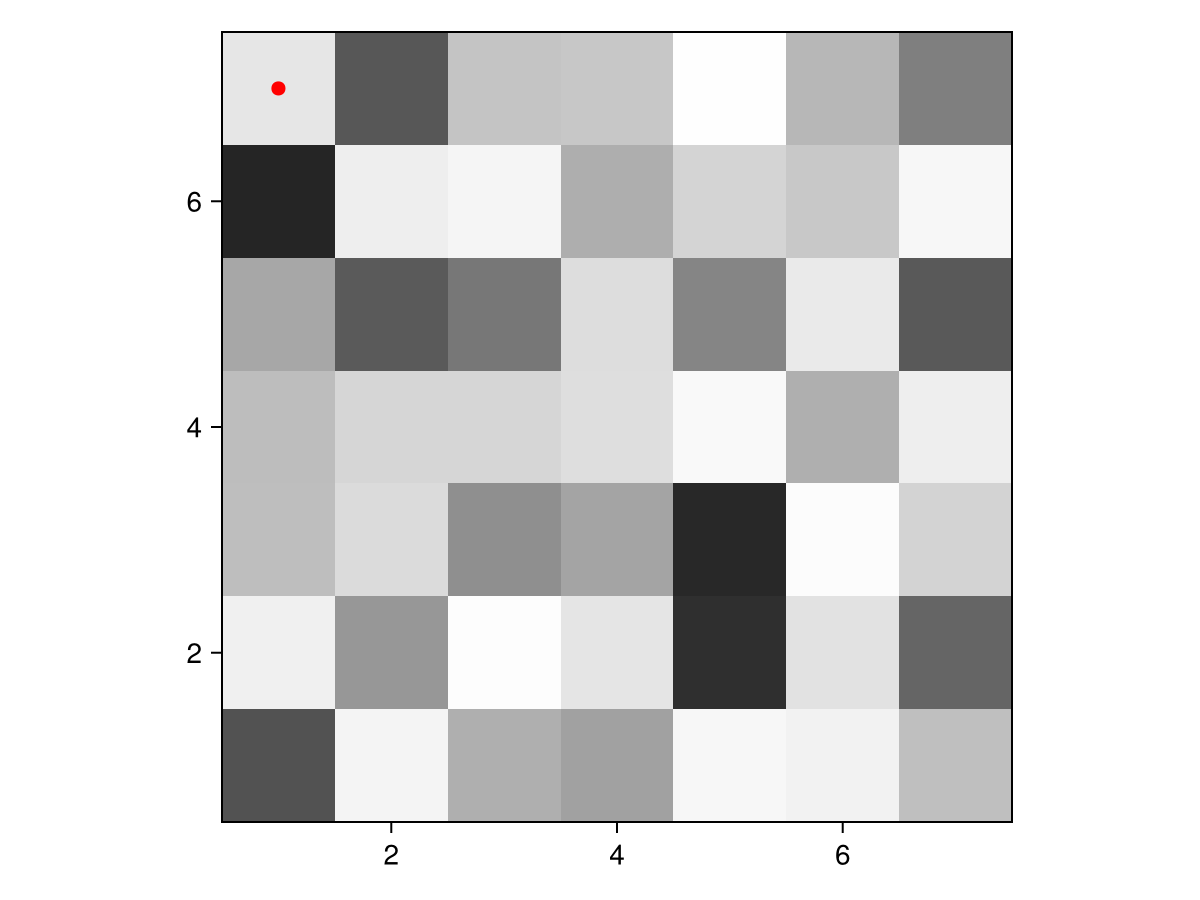

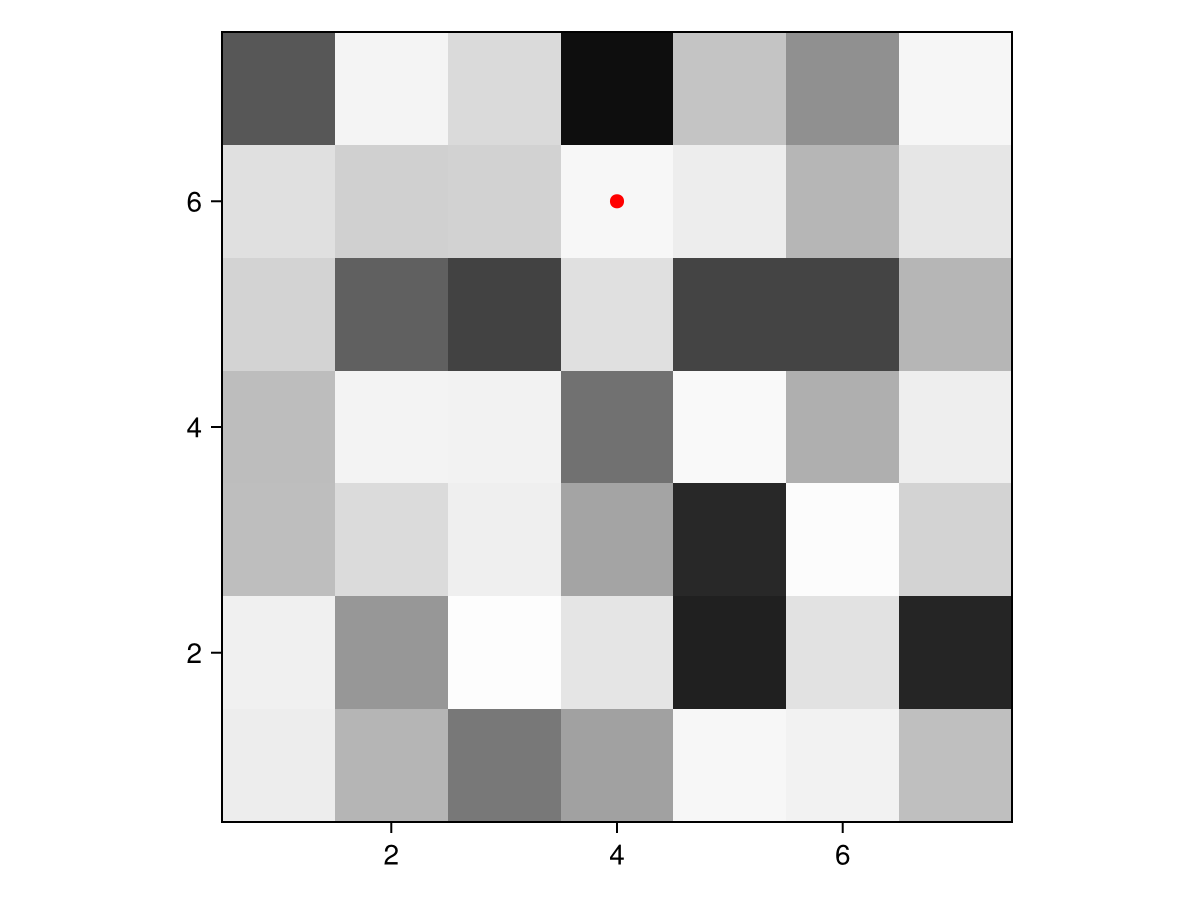

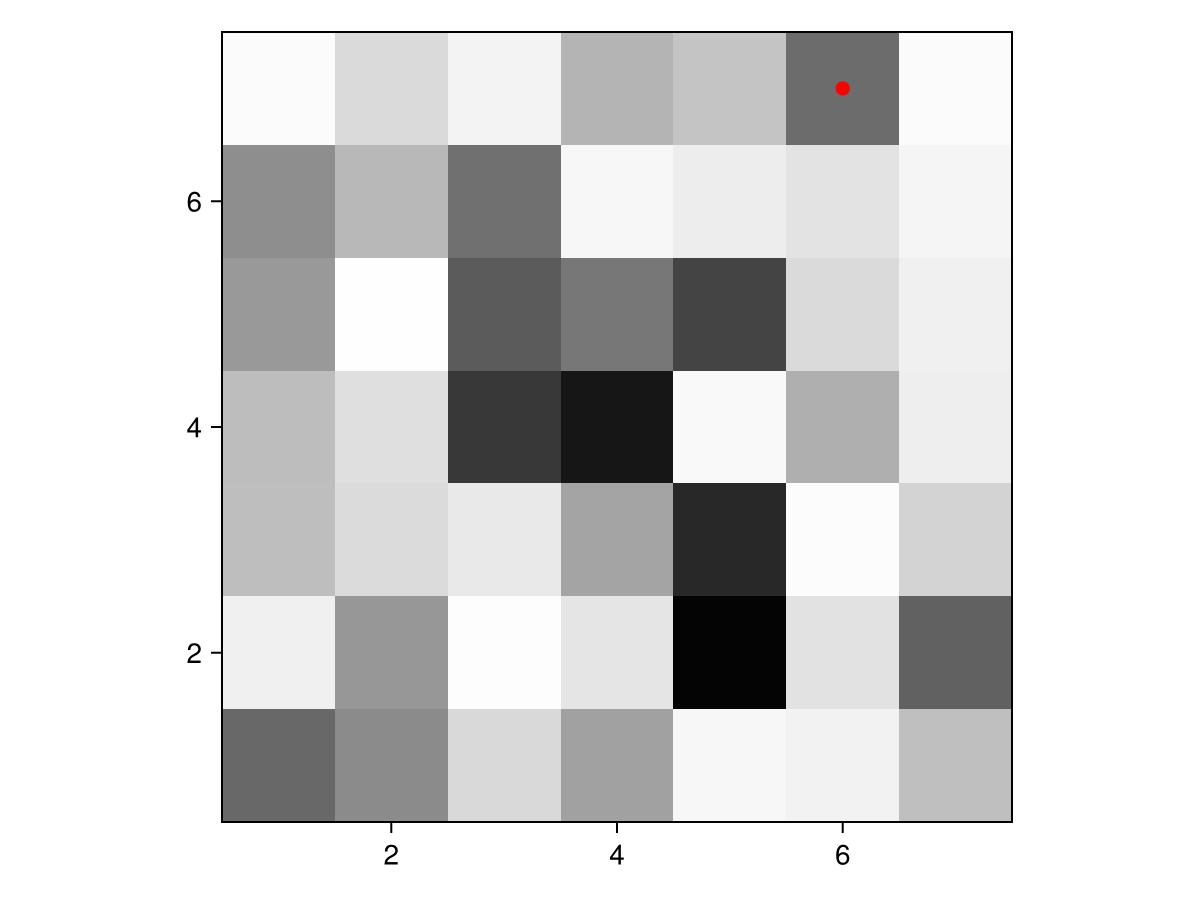

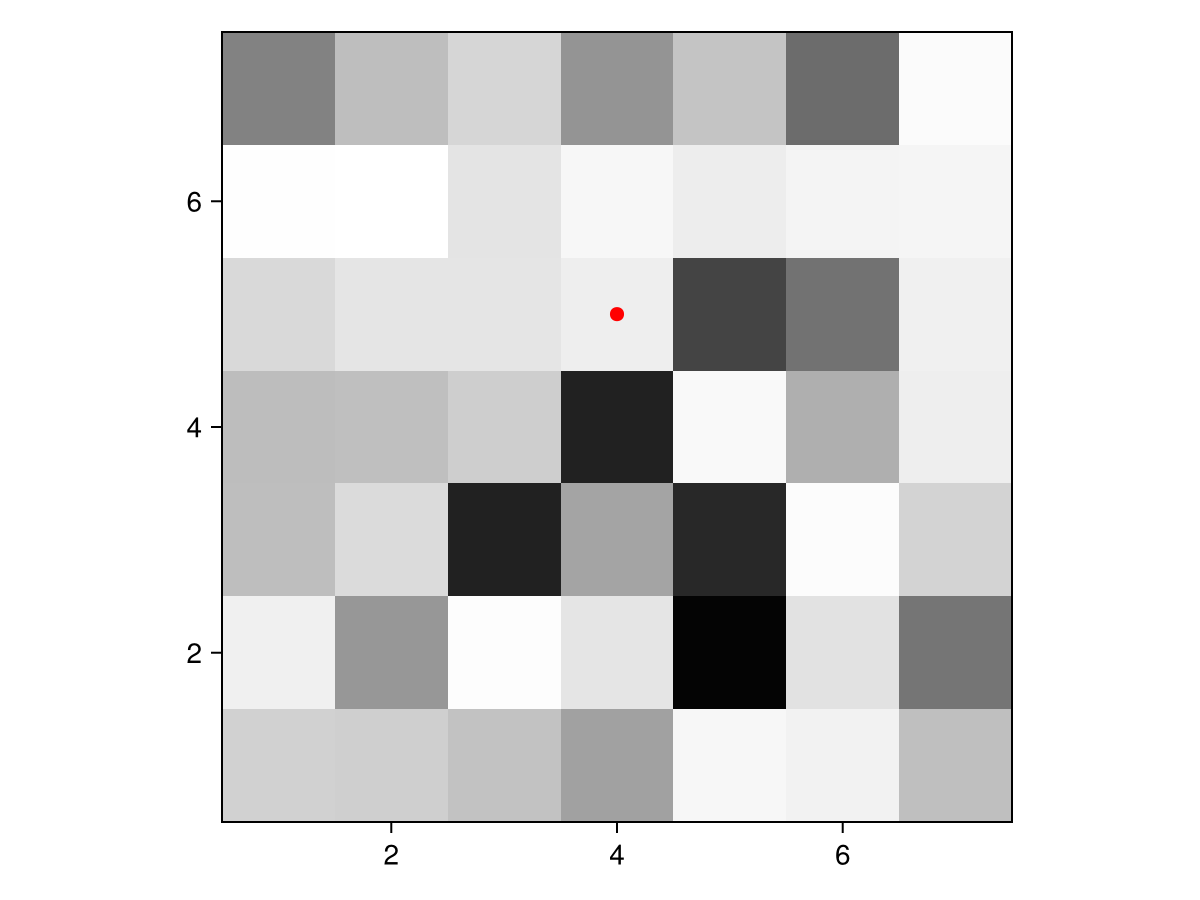

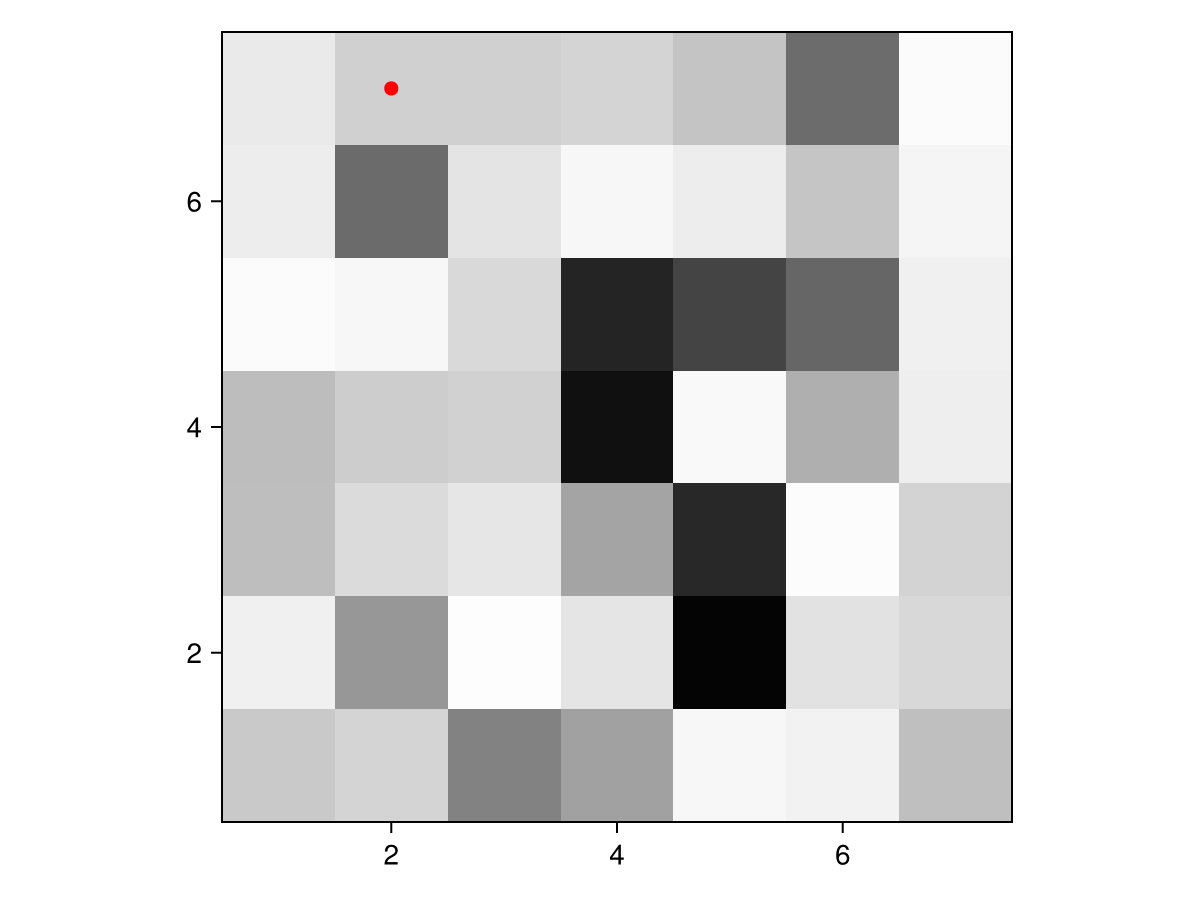

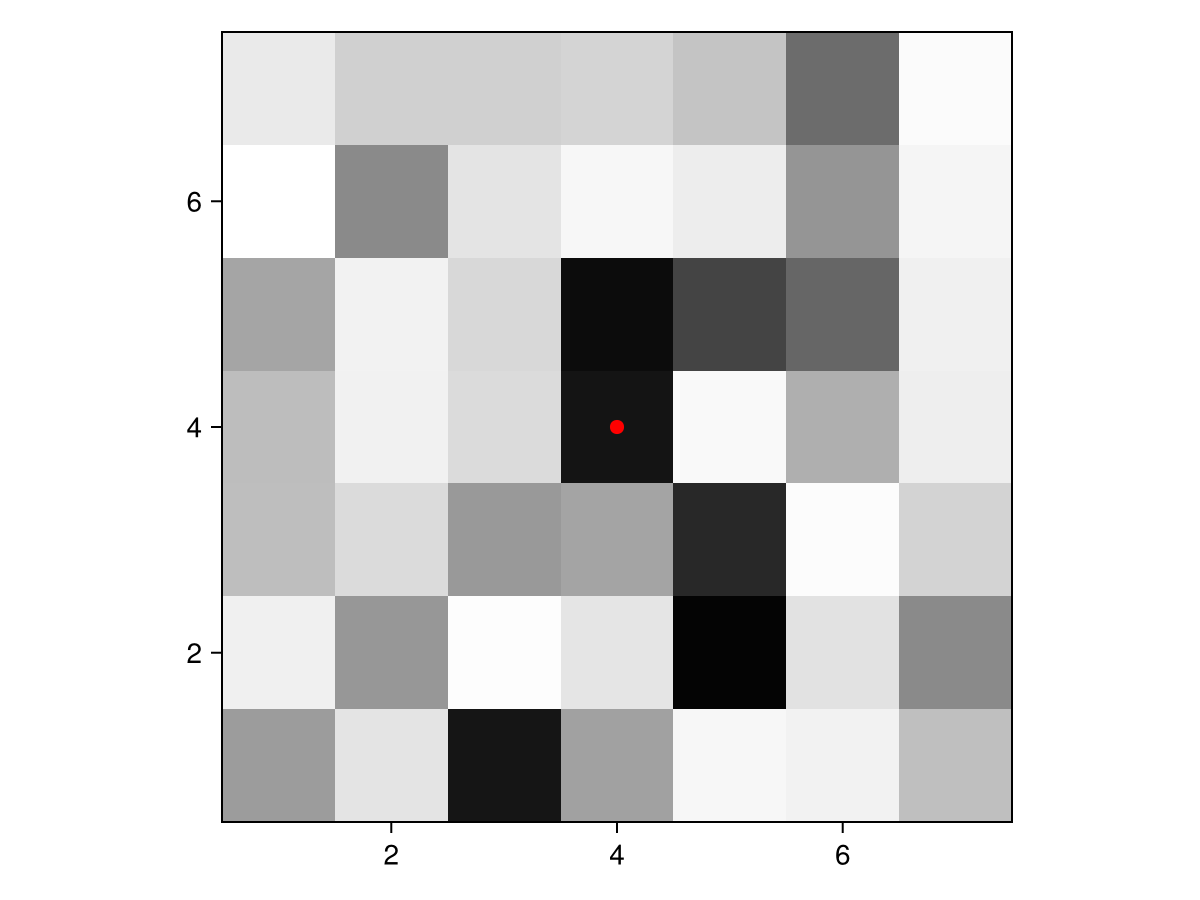

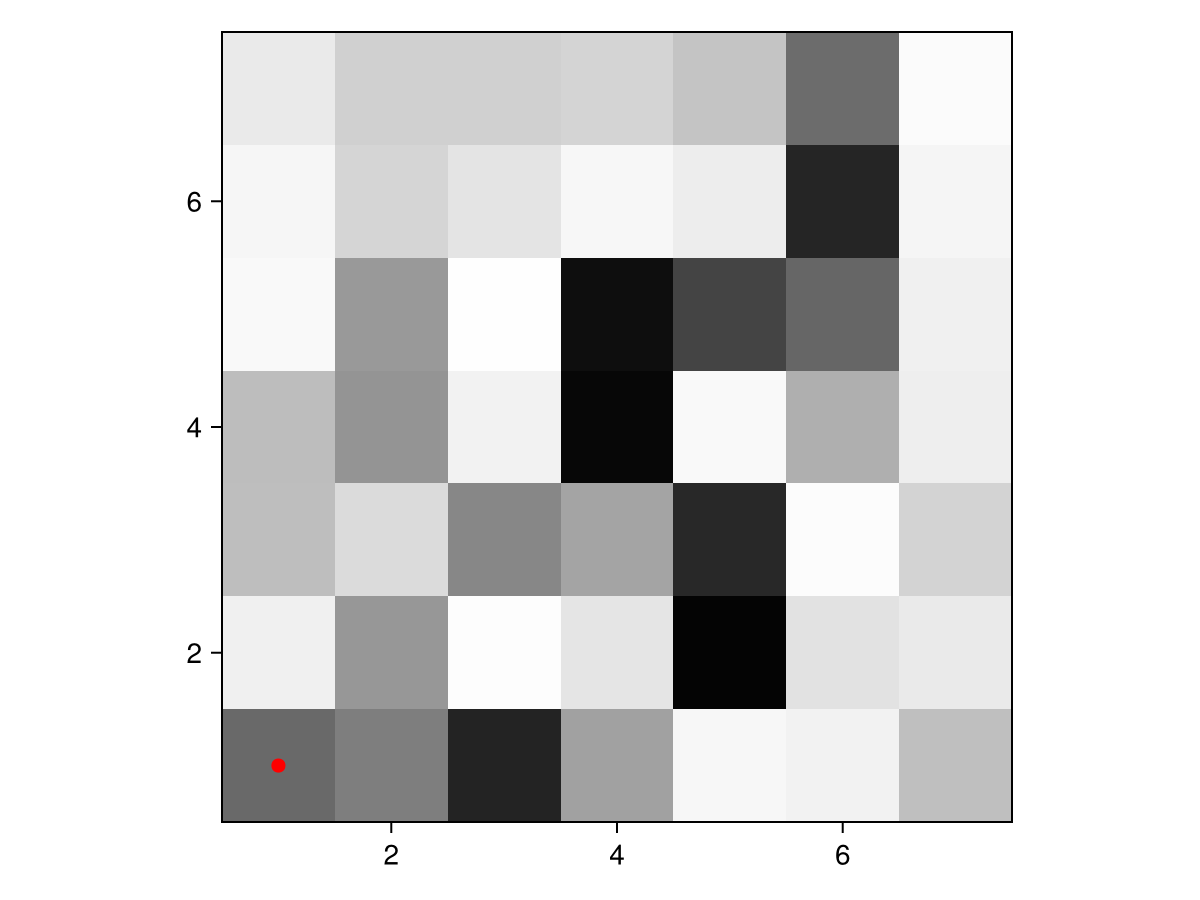

In [94]:
Random.seed!(1)
environment, start = generate_nondet_environment(7);
print_maze(environment.maze, start)

policies, traces = iterative_thompson_propose(environment, start, 49, 10, 100);

In [ ]:
print_maze(environment.maze, start)
println()
print_maze(traces[end][:maze], start)



In [109]:
Random.seed!(2)
environment, start = generate_nondet_environment(10);
print_maze(environment.maze, start)

policies, traces = iterative_thompson_propose(environment, start, 100, 50, 100);

 . . . . . . . . . .
 # . # # . # # . . .
 # . . . . . . # # #
 . . . . . . . . . #
 . . . . . # # . . .
 . # . . . # # . . .
 . . . . # . . . . .
 . . . . . . . . . X
 . G . . . . . . . .
 . . . . . . . . . .


LoadError: InterruptException: